# I.데이터 및 라이브러리 불러오기 

In [41]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as pyo
import plotly.express as px
import scipy.stats as stats
from google.cloud import bigquery
from google.oauth2 import service_account
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

In [4]:
pd.set_option('display.max_rows', None)

In [5]:
key_path = glob.glob("G:/내 드라이브/2402_ge_project/complete-tube-412307-ff85fc0c9cef.json")[0]

credentials = service_account.Credentials.from_service_account_file(key_path)

client = bigquery.Client(credentials= credentials, project = credentials.project_id)

dataset_ref = client.dataset('google_analytics_sample', project='bigquery-public-data')

In [6]:
dataset = client.get_dataset(dataset_ref)

In [7]:
tables = list(client.list_tables(dataset))
table_names = sorted([t.table_id for t in tables])

# 테이블 단위로 간단한 정보 확인
print(f"""table 개수 : {len(tables)}
tables : {", ".join(table_names[:3])}, ...
date 범위 : {table_names[0][-8:]} ~ {table_names[-1][-8:]}""")

# 결과 보다시피 매일 하나의 테이블로 구성되어 있음

table 개수 : 366
tables : ga_sessions_20160801, ga_sessions_20160802, ga_sessions_20160803, ...
date 범위 : 20160801 ~ 20170801


In [75]:
# 테이블 경로 생성
table_ref_temp = dataset_ref.table(table_names[0])

# 테이블 가져오기
table_temp = client.get_table(table_ref_temp)

# 컬럼 확인
client.list_rows(table_temp, max_results=5).to_dataframe()

visitorId  visitNumber     visitId  visitStartTime      date  \
0       <NA>            1  1470046245      1470046245  20160801   
1       <NA>            1  1470084717      1470084717  20160801   
2       <NA>            3  1470078988      1470078988  20160801   
3       <NA>            4  1470075581      1470075581  20160801   
4       <NA>           30  1470099026      1470099026  20160801   

                                              totals  \
0  {'visits': 1, 'hits': 24, 'pageviews': 17, 'ti...   
1  {'visits': 1, 'hits': 24, 'pageviews': 18, 'ti...   
2  {'visits': 1, 'hits': 27, 'pageviews': 17, 'ti...   
3  {'visits': 1, 'hits': 27, 'pageviews': 19, 'ti...   
4  {'visits': 1, 'hits': 27, 'pageviews': 17, 'ti...   

                                       trafficSource  \
0  {'referralPath': None, 'campaign': '(not set)'...   
1  {'referralPath': None, 'campaign': '(not set)'...   
2  {'referralPath': None, 'campaign': '(not set)'...   
3  {'referralPath': '/', 'campaign': '(not set)',...   
4  {'referralPath': None, 'campaign': '(not set)'...   

                                              device  \
0  {'browser': 'Firefox', 'browserVersion': 'not ...   
1  {'browser': 'Internet Explorer', 'browserVersi...   
2  {'browser': 'Safari', 'browserVersion': 'not a...   
3  {'browser': 'Chrome', 'browserVersion': 'not a...   
4  {'browser': 'Chrome', 'browserVersion': 'not a...   

                                          geoNetwork  \
0  {'continent': 'Europe', 'subContinent': 'Weste...   
1  {'continent': 'Americas', 'subContinent': 'Nor...   
2  {'continent': 'Americas', 'subContinent': 'Nor...   
3  {'continent': 'Americas', 'subContinent': 'Nor...   
4  {'continent': 'Americas', 'subContinent': 'Nor...   

                           customDimensions  \
0           [{'index': 4, 'value': 'EMEA'}]   
1  [{'index': 4, 'value': 'North America'}]   
2  [{'index': 4, 'value': 'North America'}]   
3  [{'index': 4, 'value': 'North America'}]   
4  [{'index': 4, 'value': 'North America'}]   

                                                hits        fullVisitorId  \
0  [{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...   895954260133011192   
1  [{'hitNumber': 1, 'time': 0, 'hour': 13, 'minu...  0288478011259077136   
2  [{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...  6440789996634275026   
3  [{'hitNumber': 1, 'time': 0, 'hour': 11, 'minu...  8520115029387302083   
4  [{'hitNumber': 1, 'time': 0, 'hour': 17, 'minu...  6792260745822342947   

  userId channelGrouping  socialEngagementType  
0   None  Organic Search  Not Socially Engaged  
1   None          Direct  Not Socially Engaged  
2   None  Organic Search  Not Socially Engaged  
3   None        Referral  Not Socially Engaged  
4   None  Organic Search  Not Socially Engaged

totals, trafficSource, device, geoNetwork, customDimensions, hits 컬럼: 중첩 구조 (nested data: 하나의 스키마 내에 여러 개의 데이터가 중첩된 구조)

In [7]:
# nested data 컬럼 내 데이터 확인

def format_schema_field(schema_field, indent=0):
    """
    빅쿼리 스키마의 (중첩된 구조 내부까지) 필드 이름과 데이터 타입을 출력하는 함수
    """
    
    indent_str = "  " * indent
    field_info = f"{indent_str}{schema_field.name} ({schema_field.field_type})"
    
    if schema_field.mode != "NULLABLE":
        field_info += f" - {schema_field.mode}"
    
    if schema_field.description:
        field_info += f" - {schema_field.description}"
    
    nested_indent = indent + 2
    if schema_field.field_type == "RECORD":
        for sub_field in schema_field.fields:
            field_info += "\n" + format_schema_field(sub_field, nested_indent)
    
    return field_info

# Display schemas
print("SCHEMA field for the 'totals' column:\n")
print(format_schema_field(table_temp.schema[5]))
print()

print("\nSCHEMA field for the 'trafficSource' column:\n")
print(format_schema_field(table_temp.schema[6]))
print()

print("\nSCHEMA field for the 'device' column:\n")
print(format_schema_field(table_temp.schema[7]))
print()

print("\nSCHEMA field for the 'geoNetwork' column:\n")
print(format_schema_field(table_temp.schema[8]))
print()

print("\nSCHEMA field for the 'customDimensions' column:\n")
print(format_schema_field(table_temp.schema[9]))
print()

print("\nSCHEMA field for the 'hits' column:\n")
print(format_schema_field(table_temp.schema[10]))

SCHEMA field for the 'totals' column:

totals (RECORD)
    visits (INTEGER)
    hits (INTEGER)
    pageviews (INTEGER)
    timeOnSite (INTEGER)
    bounces (INTEGER)
    transactions (INTEGER)
    transactionRevenue (INTEGER)
    newVisits (INTEGER)
    screenviews (INTEGER)
    uniqueScreenviews (INTEGER)
    timeOnScreen (INTEGER)
    totalTransactionRevenue (INTEGER)
    sessionQualityDim (INTEGER)


SCHEMA field for the 'trafficSource' column:

trafficSource (RECORD)
    referralPath (STRING)
    campaign (STRING)
    source (STRING)
    medium (STRING)
    keyword (STRING)
    adContent (STRING)
    adwordsClickInfo (RECORD)
        campaignId (INTEGER)
        adGroupId (INTEGER)
        creativeId (INTEGER)
        criteriaId (INTEGER)
        page (INTEGER)
        slot (STRING)
        criteriaParameters (STRING)
        gclId (STRING)
        customerId (INTEGER)
        adNetworkType (STRING)
        targetingCriteria (RECORD)
            boomUserlistId (INTEGER)
        isV

<분석 목표>
후행 지표: 구글 이커머스 웹사이트의 MAU 증가 시키기 
과정:
1) MAU 정의하기
2) MAU, ARPDAU 파악하기
3) 코호트 분석 통해 유저 세그먼팅 후 타겟팅 전략 제시 
4) 퍼널 분석 통해 이탈/유입 경로 파악 후 해결 방안 제시

# II. AARRR EDA 분석하기

# 1. 고객 유치(Acqusition) 분석

## 1) MAU 분석

월별 활성화 이용자 수(MAU)를 구해보자.
1) 다른 기기로 접속했더라도 user-id 값 같다면 같은 사용자로 통합
2) 활성 사용자: 기기 기준(웹과 앱)으로 구분 (웹과 앱 접속은 다른 사용자로 계산)
웹: 브라우저 인스턴스 식별 위해 쿠키에 심어둔 식별자 기준
앱: 앱을 설치할 때마다 생성하는 식별자 기준
식별자: fullVisitorId (고유한 방문자 ID로 사용자마다 고유한 값 가진다는데 무슨 기준으로 사용자를 구분한 거지 )

fullvisitorid + device 해야하나?

fullvisitorid: 쿠리를 기반으로 사용자를 추적함

* 사용자가 브라우저나 디바이스를 변경해 사이트 방문시 새로운 fullvisitorid 생성 가능. 쿠키는 브라우저/디바이스마다 별도로 저장됨

* 사용자가 쿠키 삭제할 시 새로운 fullvisitorid 생성

* google analytics의 쿠키에는 만료 기간이 설정되어 있음. 사용자가 2년 동안 사이트를 방문하지 않고, 그 후에 사이트를 다시 방문한다면 새로운 fullvisitorid가 할당

2016년 8월의 활성화 이용자 수 

In [ ]:
query = f"""
SELECT COUNT(distinct fullVisitorId) as active_users, COUNT(device.deviceCategory) as device_number, COUNT(device.browser) as browser_number
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20160831'
GROUP BY fullVisitorId
"""

result = client.query(query).result().to_dataframe()
result

20160801 ~ 20170731까지의 MAU line graph

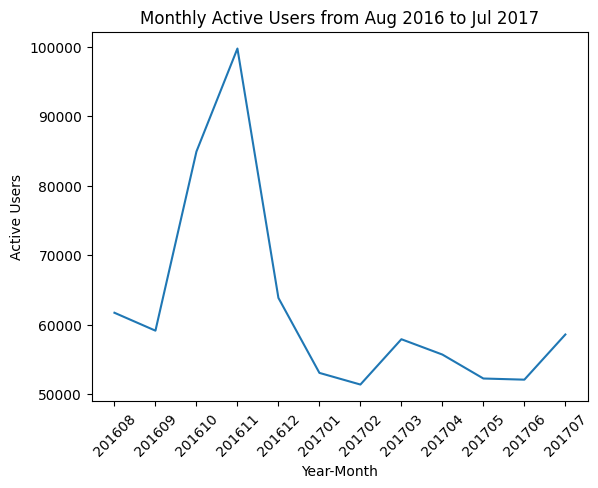

In [133]:
query = """
SELECT 
    FORMAT_DATE('%Y%m', PARSE_DATE('%Y%m%d', _TABLE_SUFFIX)) AS year_month,
    COUNT(DISTINCT fullVisitorId) AS active_users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE 
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
GROUP BY 
    year_month
ORDER BY 
    year_month
"""
result = client.query(query).result().to_dataframe()

# 데이터프레임을 이용한 lineplot 생성
sns.lineplot(data=result, x='year_month', y='active_users')
plt.xticks(rotation=45) # x축 라벨 회전
plt.title('Monthly Active Users from Aug 2016 to Jul 2017')
plt.xlabel('Year-Month')
plt.ylabel('Active Users')
plt.show()

In [135]:
result['active_users'].mean()

62511.416666666664

201609 ~ 201612에 무슨 일이 있었던 거지?

- 신규 유저가 증가했나?

- 리텐션이 좋아졌나?

## 2) NAU 분석 

MAU를 신규 유저와 기존 유저로 쪼개서 확인해보자

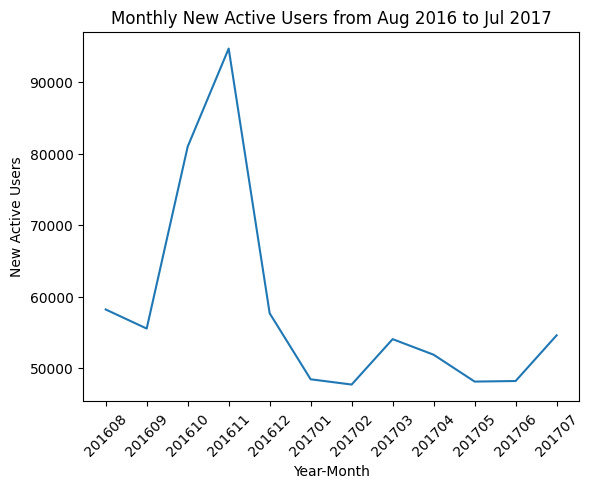

In [130]:
# 월별 NAU 확인
query = """
SELECT 
    FORMAT_DATE('%Y%m', PARSE_DATE('%Y%m%d', _TABLE_SUFFIX)) AS year_month,
    COUNT(DISTINCT fullVisitorId) AS new_users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE 
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
    AND totals.newVisits = 1
GROUP BY 
    year_month
ORDER BY 
    year_month
"""

result = client.query(query).result().to_dataframe()
# Bar plot 생성
sns.lineplot(data=result, x='year_month', y='new_users')
plt.xticks(rotation=45) # x축 라벨 회전
plt.title('Monthly New Active Users from Aug 2016 to Jul 2017')
plt.xlabel('Year-Month')
plt.ylabel('New Active Users')
plt.show()


In [132]:
result['new_users'].mean()

58361.75

신규 유저의 증가가 mau 증가에도 영향을 미쳤다는 걸 확인할 수 있음. 다만 왜?

신규 유저들이 어느 페이지를 방문했는지 확인해보자 

1. 201610

C:\Users\USER\AppData\Local\Temp\ipykernel_3920\763880906.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='new_users', y='landingScreenName', data=top5_landing_pages, palette='coolwarm')  # y축에 landingScreenName을 사용하여 가로 막대 그래프 생성


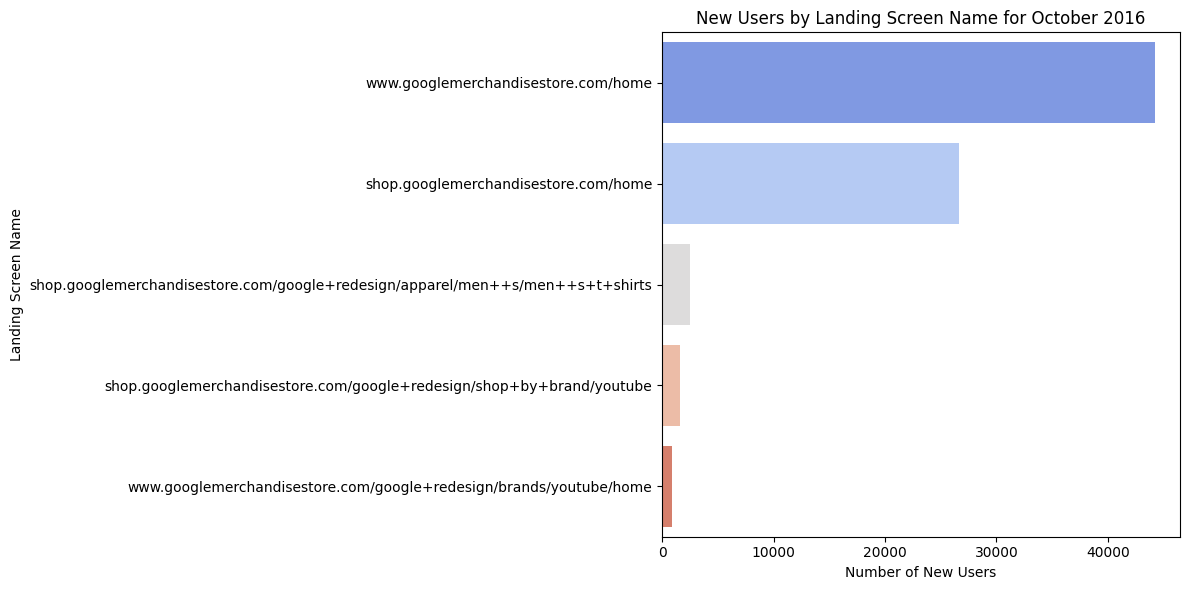

In [21]:
# hits.appInfo.landingScreenName: 세션의 방문 화면
query = """
WITH first_visits AS (
  SELECT
    fullVisitorId,
    (SELECT hits.appInfo.landingScreenName FROM UNNEST(hits) hits WHERE hits.type='PAGE' AND hits.isEntrance IS TRUE LIMIT 1) AS landingScreenName
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_201610*`
  WHERE
    visitNumber = 1
)

SELECT
  landingScreenName,
  COUNT(fullVisitorId) AS new_users
FROM
  first_visits
GROUP BY
  landingScreenName
ORDER BY
  new_users DESC
"""

result = client.query(query).result().to_dataframe()

# 상위 5개의 landingScreenName만 추출하기 위해 new_users로 정렬하고 상위 5개만 선택
top5_landing_pages = result.sort_values('new_users', ascending=False).head(5)

# 막대 그래프 생성
plt.figure(figsize=(12, 6))  # 그래프 크기 조정
sns.barplot(x='new_users', y='landingScreenName', data=top5_landing_pages, palette='coolwarm')  # y축에 landingScreenName을 사용하여 가로 막대 그래프 생성

# 그래프 제목과 축 라벨 추가
plt.title('New Users by Landing Screen Name for October 2016')
plt.xlabel('Number of New Users')
plt.ylabel('Landing Screen Name')

# 그래프 표시
plt.tight_layout()
plt.show()


2. 201611

C:\Users\USER\AppData\Local\Temp\ipykernel_3920\296770558.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='new_users', y='landingScreenName', data=top5_landing_pages, palette='coolwarm')  # y축에 landingScreenName을 사용하여 가로 막대 그래프 생성


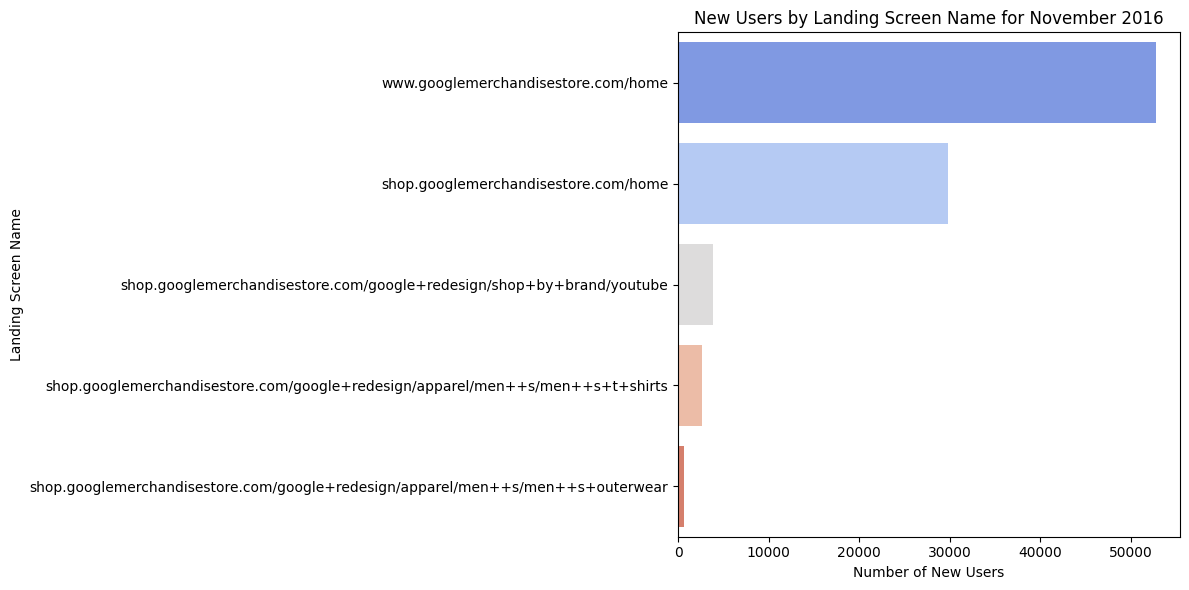

In [23]:
# hits.appInfo.landingScreenName: 세션의 방문 화면
query = """
WITH first_visits AS (
  SELECT
    fullVisitorId,
    (SELECT hits.appInfo.landingScreenName FROM UNNEST(hits) hits WHERE hits.type='PAGE' AND hits.isEntrance IS TRUE LIMIT 1) AS landingScreenName
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_201611*`
  WHERE
    visitNumber = 1
)

SELECT
  landingScreenName,
  COUNT(fullVisitorId) AS new_users
FROM
  first_visits
GROUP BY
  landingScreenName
ORDER BY
  new_users DESC
"""

result = client.query(query).result().to_dataframe()

# 상위 5개의 landingScreenName만 추출하기 위해 new_users로 정렬하고 상위 5개만 선택
top5_landing_pages = result.sort_values('new_users', ascending=False).head(5)

# 막대 그래프 생성
plt.figure(figsize=(12, 6))  # 그래프 크기 조정
sns.barplot(x='new_users', y='landingScreenName', data=top5_landing_pages, palette='coolwarm')  # y축에 landingScreenName을 사용하여 가로 막대 그래프 생성

# 그래프 제목과 축 라벨 추가
plt.title('New Users by Landing Screen Name for November 2016')
plt.xlabel('Number of New Users')
plt.ylabel('Landing Screen Name')

# 그래프 표시
plt.tight_layout()
plt.show()


3. 전체 기간 

C:\Users\USER\AppData\Local\Temp\ipykernel_21844\318376275.py:32: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




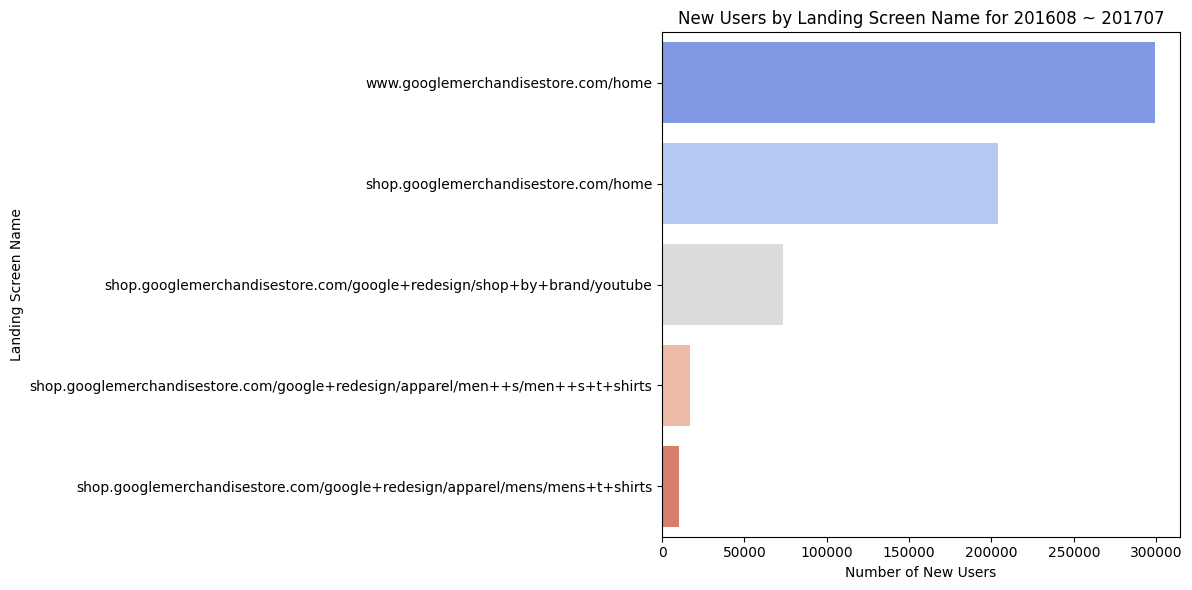

In [45]:
# hits.appInfo.landingScreenName: 세션의 방문 화면
query = """
WITH first_visits AS (
  SELECT
    fullVisitorId,
    (SELECT hits.appInfo.landingScreenName FROM UNNEST(hits) hits WHERE hits.type='PAGE' AND hits.isEntrance IS TRUE LIMIT 1) AS landingScreenName
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    visitNumber = 1
)

SELECT
  landingScreenName,
  COUNT(fullVisitorId) AS new_users
FROM
  first_visits
GROUP BY
  landingScreenName
ORDER BY
  new_users DESC
"""

result = client.query(query).result().to_dataframe()

# 상위 5개의 landingScreenName만 추출하기 위해 new_users로 정렬하고 상위 5개만 선택
top5_landing_pages = result.sort_values('new_users', ascending=False).head(5)

# 막대 그래프 생성
plt.figure(figsize=(12, 6))  # 그래프 크기 조정
sns.barplot(x='new_users', y='landingScreenName', data=top5_landing_pages, palette='coolwarm')  # y축에 landingScreenName을 사용하여 가로 막대 그래프 생성

# 그래프 제목과 축 라벨 추가
plt.title('New Users by Landing Screen Name for 201608 ~ 201707')
plt.xlabel('Number of New Users')
plt.ylabel('Landing Screen Name')

# 그래프 표시
plt.tight_layout()
plt.show()


## 3) EAU 분석 

EAU/RAU는 어떻게 계산해야할까................ 하

## 4) RAU 분석 

## 5) Stickiness 분석 

#### DAU/MAU 비율을 통해 stickiness 측정

사용자들이 사이트에 얼마나 자주 돌아오는지 확인 가능


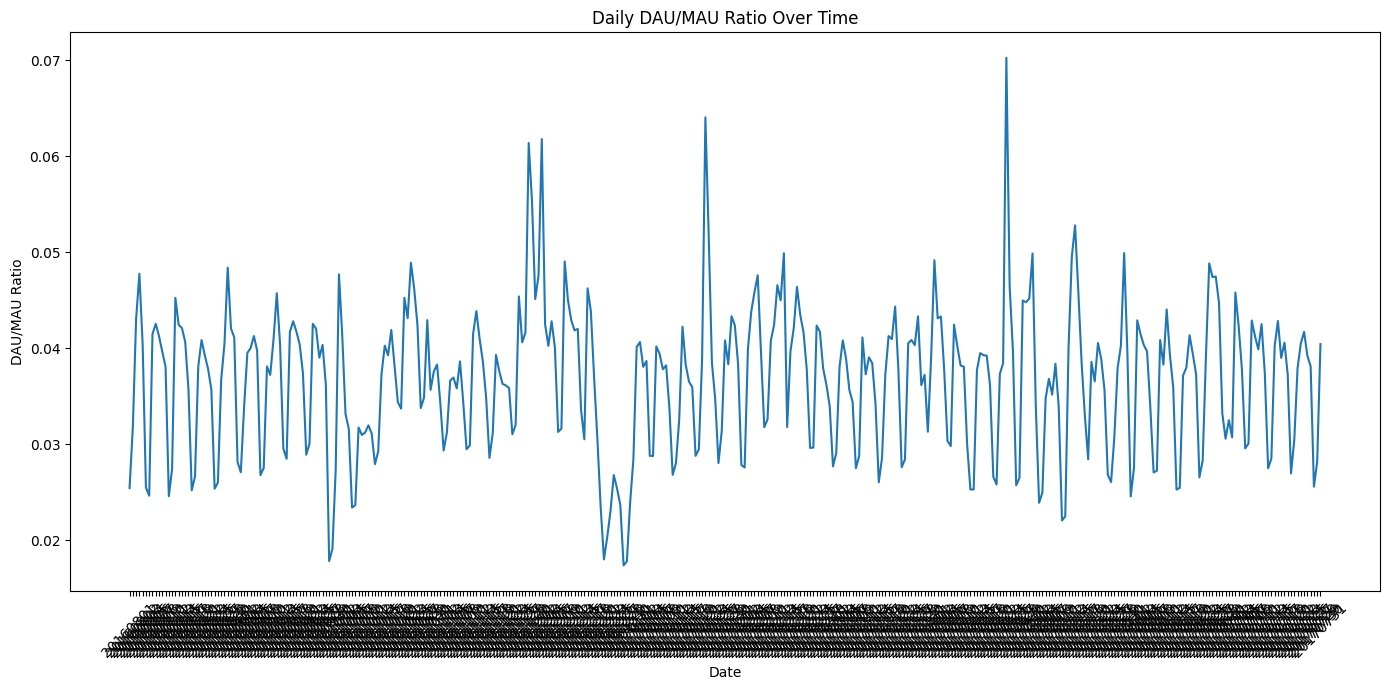

In [25]:
query = """
WITH daily_active_users AS (
    SELECT 
        FORMAT_DATE('%Y%m%d', PARSE_DATE('%Y%m%d', _TABLE_SUFFIX)) AS date,
        COUNT(DISTINCT fullVisitorId) AS dau
    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE 
        _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
    GROUP BY 
        date
),
monthly_active_users AS (
    SELECT 
        FORMAT_DATE('%Y%m', PARSE_DATE('%Y%m%d', _TABLE_SUFFIX)) AS year_month,
        COUNT(DISTINCT fullVisitorId) AS mau
    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE 
        _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
    GROUP BY 
        year_month
),
dau_mau_ratio AS (
    SELECT 
        dau.date,
        dau.dau,
        mau.mau,
        (dau.dau / mau.mau) AS dau_mau_ratio
    FROM 
        daily_active_users dau
    JOIN 
        monthly_active_users mau ON FORMAT_DATE('%Y%m', PARSE_DATE('%Y%m%d', dau.date)) = mau.year_month
)
SELECT 
    *
FROM 
    dau_mau_ratio
ORDER BY 
    date
"""

dau_mau_df = client.query(query).result().to_dataframe()



# DAU/MAU 비율의 시간에 따른 변화를 시각화
plt.figure(figsize=(14, 7))
sns.lineplot(data=dau_mau_df, x='date', y='dau_mau_ratio')

plt.title('Daily DAU/MAU Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('DAU/MAU Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


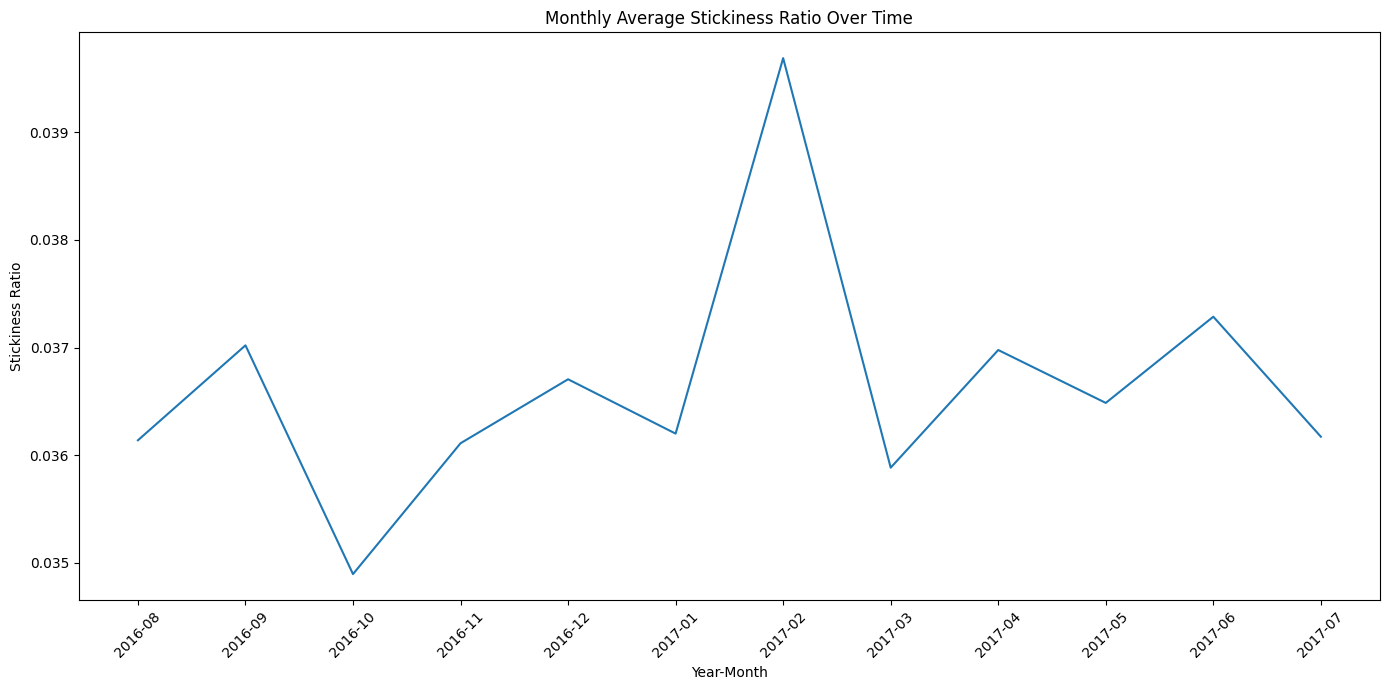

In [26]:
# 'date' 열을 datetime 타입으로 변환
dau_mau_df['date'] = pd.to_datetime(dau_mau_df['date'])

# 연-월 정보만 추출하여 새로운 열 생성
dau_mau_df['year_month'] = dau_mau_df['date'].dt.strftime('%Y-%m')

# 연-월별 평균 DAU/MAU 비율 계산
monthly_dau_mau = dau_mau_df.groupby('year_month')['dau_mau_ratio'].mean().reset_index()

# 시각화
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_dau_mau, x='year_month', y='dau_mau_ratio')

plt.title('Monthly Average Stickiness Ratio Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Stickiness Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 6) 방문 수와 페이지뷰 분석

방문 수와 페이지뷰: 사이트의 상황을 진단 가능

방문수: 웹사이트에 유입된 수 (= 세션 수)
페이지뷰: 웹사이트의 페이지가 열려진 횟수 (방문수와 같거나 큼)

ex 내가 웹사이트 방문해서 10개 페이지 열었다면 페이지 뷰 = 10, 방문 수 = 1


방문 수 증가하는데 페이지뷰 감소 가능 
방문 수 감소하는데 페이지뷰 증가 가능 

1. 방문 수 증가, 페이지뷰 증가 = 신규 방문 + 재방문 수 증가

방문당 페이지뷰: 특정 기간의 전체 페이지뷰 / 특정 기간의 방문 수 
-> 한 번 방문할 때 얼마나 많은 페이지를 열어보는지에 대한 평균값 

2. 방문 수 증가, 페이지뷰 감소 = 신규 방문은 늘었으나 붙잡아 두기 힘듦

3. 방문 수 감소, 페이지뷰 증가 = 커뮤니티 등

4. 방문수 감소, 페이지뷰 감소 = 원인은 여러 가지
1) 유입 채널 축소 2) 검색 엔진 및 검색 광고의 경쟁 심화 3) (재방문의 경우) 사이트 신뢰도 4) 부족한 콘텐츠(상품) 5) 느린 업데이트 6) 가격 경쟁력 저하 

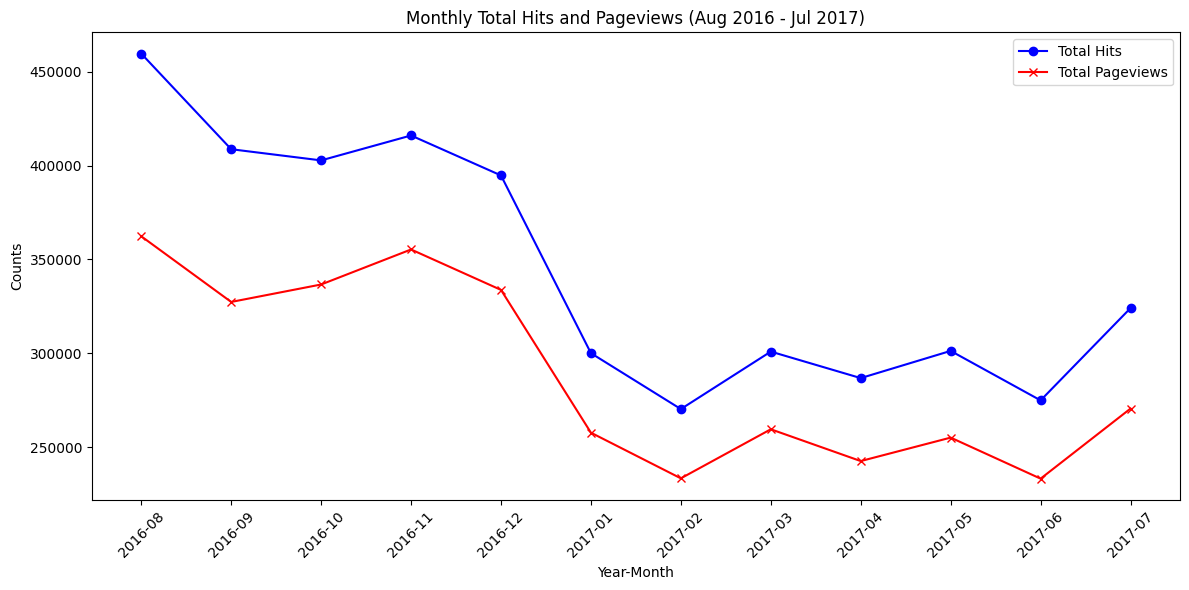

In [24]:
# totals.hits: 세션 내의 총 조회수 (이건 방문 수가 아닌 것 같은데..)
# totals.pageviews: 세션 내의 총 페이지뷰 수

query = """
SELECT
    FORMAT_DATE('%Y-%m', PARSE_DATE('%Y%m%d', _TABLE_SUFFIX)) AS year_month,
    SUM(totals.hits) AS total_hits,
    SUM(totals.pageviews) AS total_pageviews
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
GROUP BY
    year_month
ORDER BY
    year_month
"""

# 쿼리 실행
query_result = client.query(query).result().to_dataframe()

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(query_result['year_month'], query_result['total_hits'], label='Total Hits', color='blue', marker='o')
plt.plot(query_result['year_month'], query_result['total_pageviews'], label='Total Pageviews', color='red', marker='x')

plt.title('Monthly Total Hits and Pageviews (Aug 2016 - Jul 2017)')
plt.xlabel('Year-Month')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
# 유입 채널에 따른 사용자 시각화 
# channelGrouping: 이 보기의 최종 사용자 세션과 연결된 기본 채널 그룹 (뭔 소리지)

query = """
SELECT
    channelGrouping, COUNT(channelGrouping) as cg_num
FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
GROUP BY
    channelGrouping
"""

query_result = client.query(query).result().to_dataframe()
query_result_sorted = query_result.sort_values('cg_num', ascending=False)



# 채널별 방문 횟수 막대 그래프를 그립니다.
plt.figure(figsize=(10, 6))  # 그래프 크기 설정

sns.barplot(data=query_result_sorted, x='channelGrouping', y='cg_num')

plt.title('User Visits by Channel (Sorted)')  # 그래프 제목
plt.xlabel('Channel Grouping')  # x축 라벨
plt.ylabel('Visit Counts')  # y축 라벨
plt.xticks(rotation=45)  # x축 라벨 회전
plt.tight_layout()  # 레이아웃 조정
plt.show()  # 그래프 표시b

## 7) UTM 분석

UTM 파라미터 분석을 통해 채널별 성과 측정을 할 수 있음. 

* 광고 
* 소스
* 캠페인
* 매체
 

### 광고

In [16]:
# trafficSource.adContent: 트래픽 소스의 광고 콘텐츠
# utm_content URL 매개변수로 설정 가능 

query = """
SELECT
  trafficSource.adContent AS AdContent,
  COUNT(DISTINCT fullVisitorId) AS Users,
  FORMAT_DATE('%Y%m', PARSE_DATE('%Y%m%d', date)) AS YearMonth
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  trafficSource.adContent IS NOT NULL
GROUP BY
  AdContent, YearMonth
ORDER BY
  YearMonth, Users DESC

"""

ad_utm = client.query(query).result().to_dataframe()

C:\Users\USER\AppData\Local\Temp\ipykernel_18296\3257153874.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




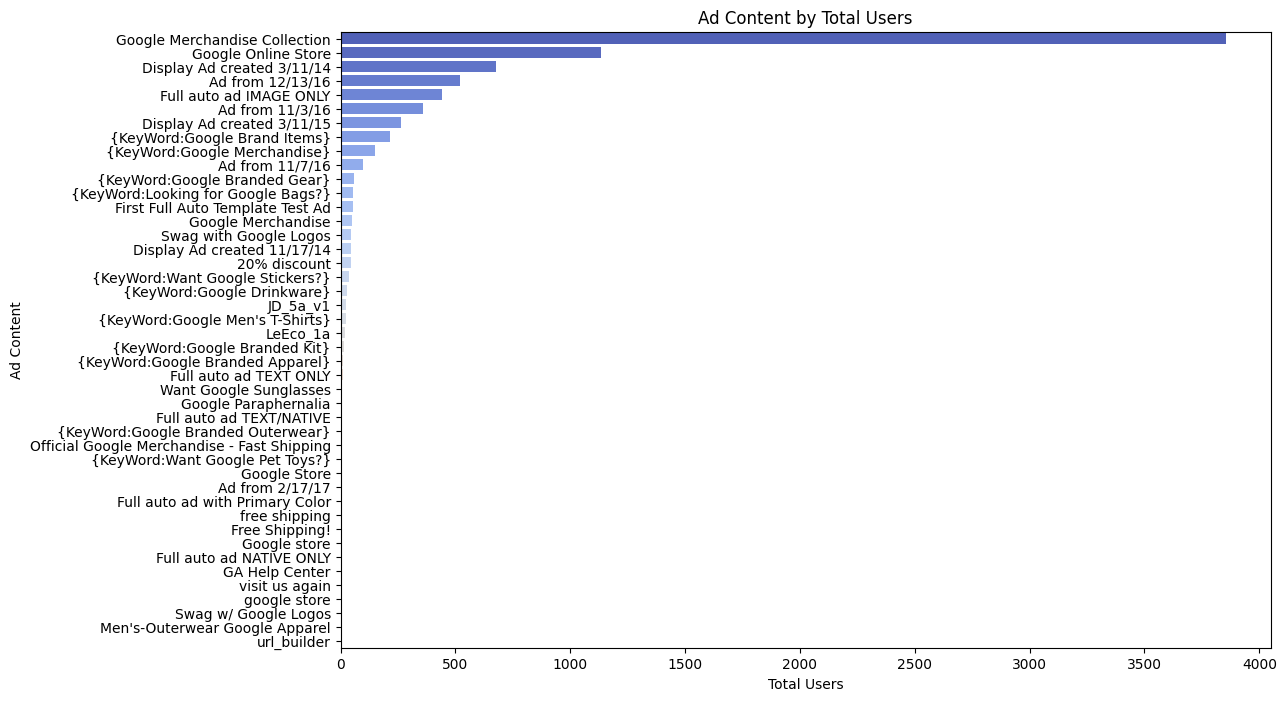

In [18]:
# 광고 콘텐츠별 총 사용자 수를 계산
df_grouped = ad_utm.groupby('AdContent')['Users'].sum().reset_index()

# 광고 콘텐츠별 총 사용자 수를 기준으로 내림차순 정렬
df_grouped_sorted = df_grouped.sort_values(by='Users', ascending=False)

# 막대 그래프 생성
plt.figure(figsize=(12, 8))
sns.barplot(data=df_grouped_sorted, x='Users', y='AdContent', palette='coolwarm')
plt.title('Ad Content by Total Users')
plt.xlabel('Total Users')
plt.ylabel('Ad Content')
plt.show()

다른 값들이 너무 안 보이니까 google merchandise collection은 제외하고 시각화해보자 

In [20]:
# google merchandise collection 제외 시각화

df_filtered = df_grouped_sorted[df_grouped_sorted['AdContent'] != 'Google Merchandise Collection']
df_filtered = df_filtered[df_filtered['AdContent'] != 'Google Online Store']

# 막대 그래프 생성
plt.figure(figsize=(12, 8))
sns.barplot(data=df_filtered, x='Users', y='AdContent', palette='coolwarm')
plt.title('Ad Content by Total Users (Excluding Google Merchandise Collection)')
plt.xlabel('Total Users')
plt.ylabel('Ad Content')
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_18296\3080296782.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




### 캠페인

In [21]:
# trafficSource.campaign: 캠페인의 가치
# 보통 utm_campaign URL 매개변수로 설정


query = """
SELECT
  trafficSource.campaign AS Campaign,
  COUNT(DISTINCT fullVisitorId) AS Users,
  FORMAT_DATE('%Y%m', PARSE_DATE('%Y%m%d', date)) AS YearMonth
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  trafficSource.campaign IS NOT NULL
GROUP BY
  Campaign, YearMonth
ORDER BY
  YearMonth, Users DESC

"""

cam_utm = client.query(query).result().to_dataframe()

C:\Users\USER\AppData\Local\Temp\ipykernel_18296\2291048274.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




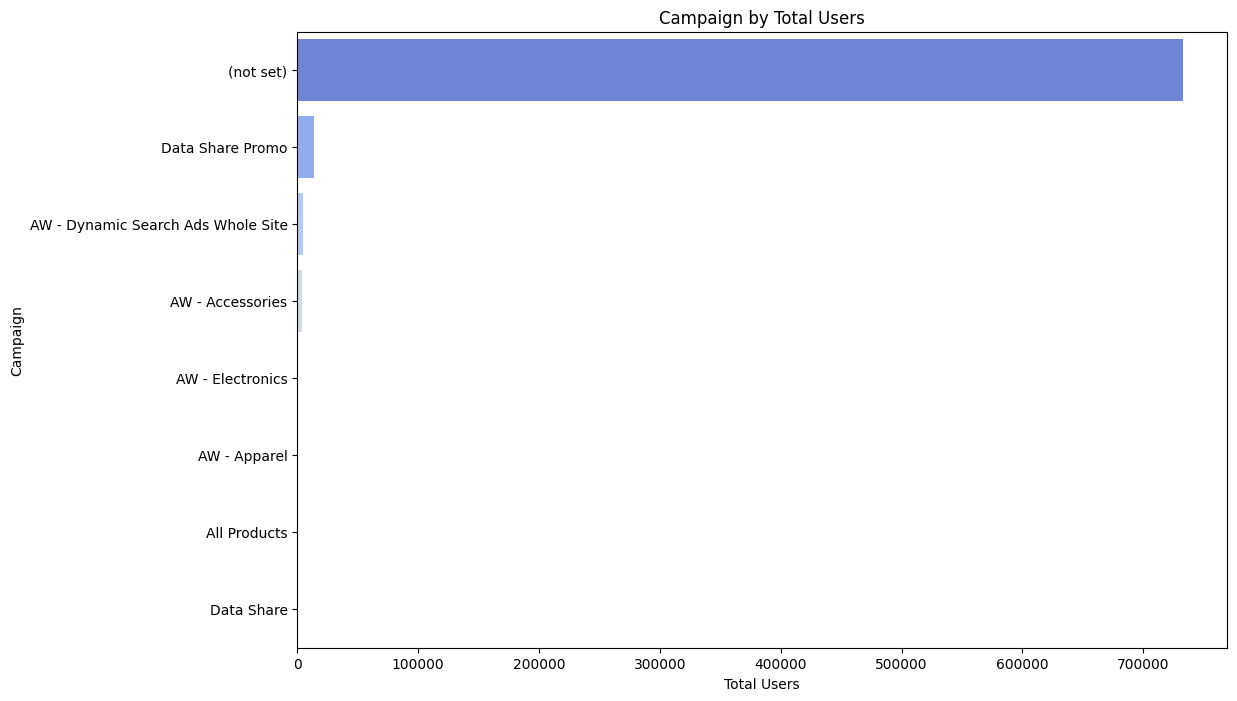

In [22]:
df_grouped = cam_utm.groupby('Campaign')['Users'].sum().reset_index()

df_grouped_sorted = df_grouped.sort_values(by='Users', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=df_grouped_sorted, x='Users', y='Campaign', palette='coolwarm')
plt.title('Campaign by Total Users')
plt.xlabel('Total Users')
plt.ylabel('Campaign')
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_18296\69039399.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




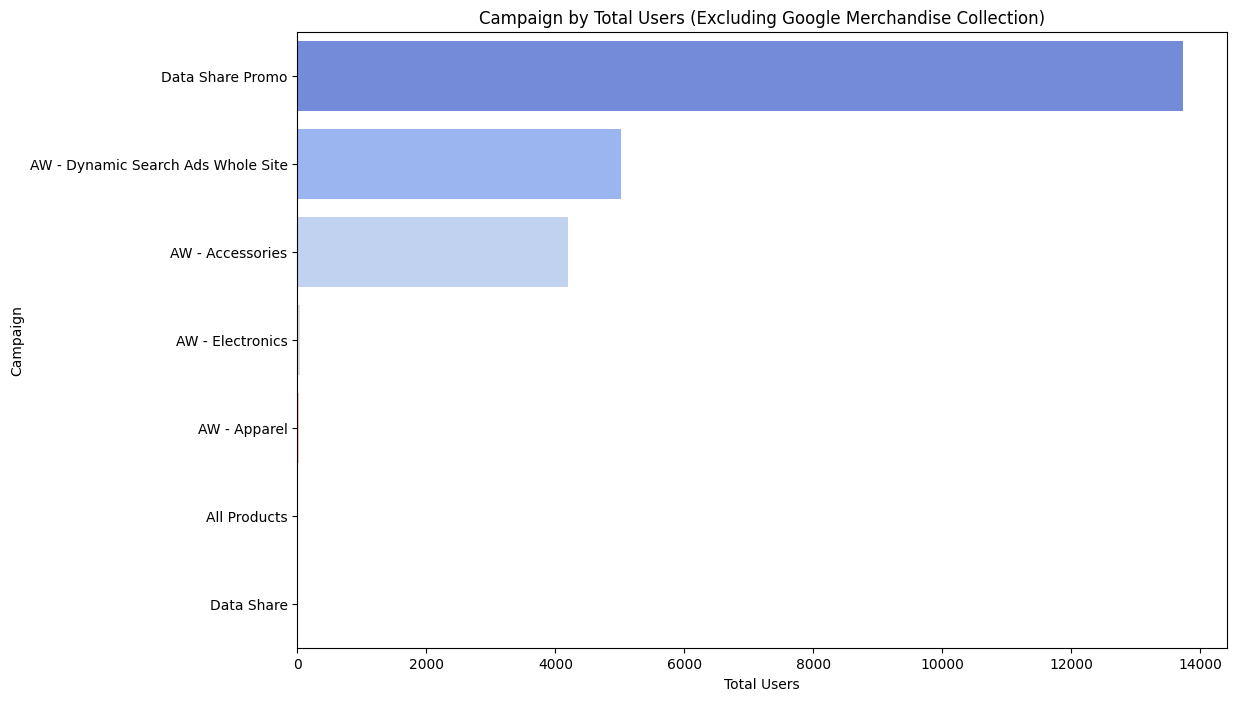

In [24]:
# not set 제외
df_filtered = df_grouped_sorted[df_grouped_sorted['Campaign'] != '(not set)']

# 막대 그래프 생성
plt.figure(figsize=(12, 8))
sns.barplot(data=df_filtered, x='Users', y='Campaign', palette='coolwarm')
plt.title('Campaign by Total Users (Excluding Google Merchandise Collection)')
plt.xlabel('Total Users')
plt.ylabel('Campaign')
plt.show()


### medium

In [25]:
# trafficSource.medium: 트래픽 소스의 매체

query = """
SELECT
  trafficSource.medium AS Medium,
  COUNT(DISTINCT fullVisitorId) AS Users,
  FORMAT_DATE('%Y%m', PARSE_DATE('%Y%m%d', date)) AS YearMonth
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  trafficSource.medium IS NOT NULL
GROUP BY
  Medium, YearMonth
ORDER BY
  YearMonth, Users DESC

"""

med_utm = client.query(query).result().to_dataframe()

C:\Users\USER\AppData\Local\Temp\ipykernel_18296\909921067.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




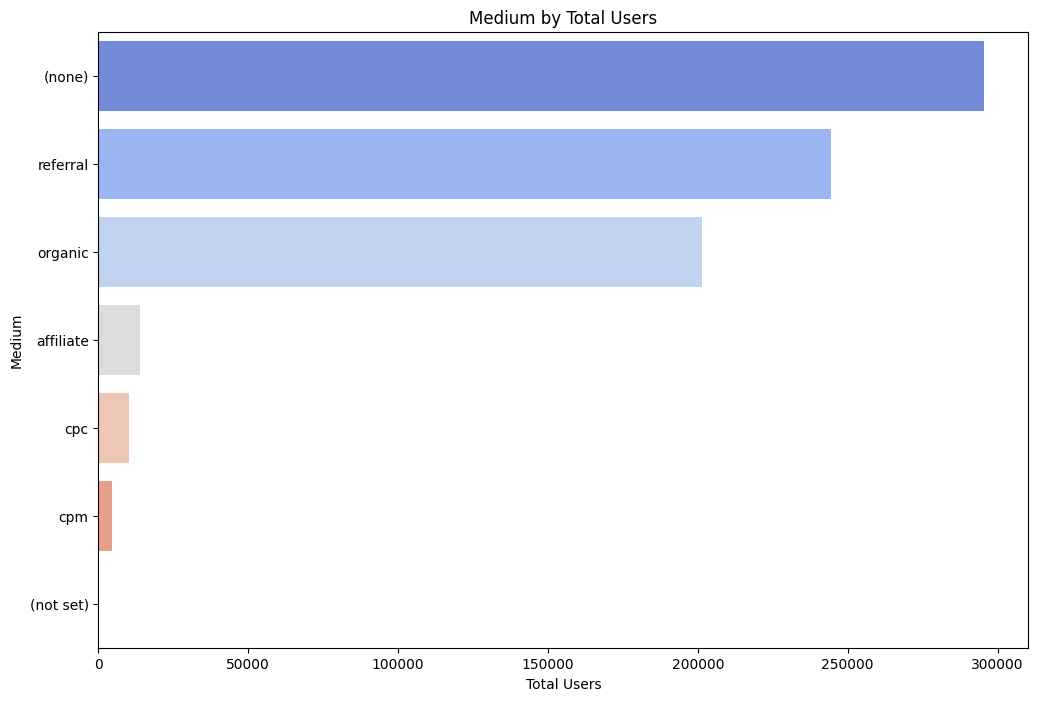

In [26]:
df_grouped = med_utm.groupby('Medium')['Users'].sum().reset_index()

df_grouped_sorted = df_grouped.sort_values(by='Users', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=df_grouped_sorted, x='Users', y='Medium', palette='coolwarm')
plt.title('Medium by Total Users')
plt.xlabel('Total Users')
plt.ylabel('Medium')
plt.show()

### source

In [27]:
# trafficSource.source: 트래픽 소스의 소스	

query = """
SELECT
  trafficSource.source AS Source,
  COUNT(DISTINCT fullVisitorId) AS Users,
  FORMAT_DATE('%Y%m', PARSE_DATE('%Y%m%d', date)) AS YearMonth
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  trafficSource.source IS NOT NULL
GROUP BY
  Source, YearMonth
ORDER BY
  YearMonth, Users DESC

"""

sor_utm = client.query(query).result().to_dataframe()

C:\Users\USER\AppData\Local\Temp\ipykernel_18296\3967742739.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




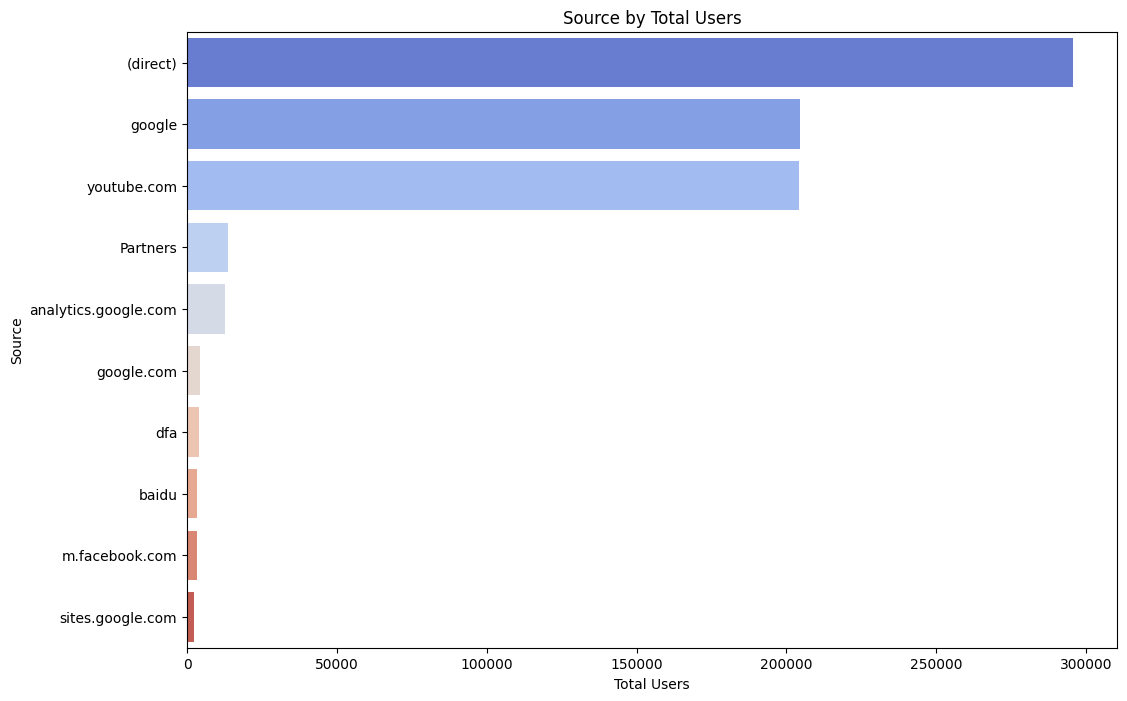

In [30]:
df_grouped = sor_utm.groupby('Source')['Users'].sum().reset_index()

df_grouped_sorted = df_grouped.sort_values(by='Users', ascending=False)

top_ad_contents = df_grouped_sorted.head(10)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_ad_contents, x='Users', y='Source', palette='coolwarm')
plt.title('Source by Total Users')
plt.xlabel('Total Users')
plt.ylabel('Source')
plt.show()

# 2. 활성화(Activation) 분석

## 1. 퍼널 분석

핵심 3가지
* 핵심 가치를 경험하는 시점(사용자 입장에서)과 그곳으로 연결되는 각 단계를 잘 정의했나?
* 각 단계별 전환율을 어떤 기준으로 측정하는가?
-> 1) 트래픽 기준 2) 사용자 기준 
* 코호트에 따른 퍼널별 전환율을 보고 있는가?
-> 코호트별로 쪼개서 살펴보면 각 퍼널에 영향을 미치는 선행지표 파악이 수월해짐 

### 고객 여정 퍼널 시각화

* hits.eCommerceAction.action_type: 액션 유형

-> 액션 유형은 구매 여정에서 중요 단계를 나타냄 근데 이게 세션 기준인지 뭔지는 안 나와있군 

* 제품 목록은 1, 
제품 세부정보 보기는 2, 
장바구니에 제품 추가는 3, 
장바구니에서 제품 삭제는 4, 
결제는 5, 
구매 완료는 6, 
구매 환불은 7, 
결제 옵션은 8, 
알 수 없음은 0


In [50]:
# 전체 데이터 퍼널 분석 
query = """
        SELECT 
            CASE WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
                 WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
                 WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
                 WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
            END AS action,
            COUNT(fullVisitorID) AS users,
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
            UNNEST(hits) AS hits, 
            UNNEST(hits.product) AS product
        WHERE
            _TABLE_SUFFIX BETWEEN '20160801' AND '20170801' AND  (
            hits.eCommerceAction.action_type != '0'  AND
            hits.eCommerceAction.action_type != '4'  AND
            hits.eCommerceAction.action_type != '3'
            )
        GROUP BY 
            action
        ORDER BY 
            users DESC
        """
# 월별로 확인하는 게 좋을듯 
result = client.query(query).result().to_dataframe()

# 데이터 유형을 int나 float로 변환
data = dict(
    number = result['users'],
    stage = result['action']
)

# Plotly Express를 사용하여 퍼널 그래프 생성
funnel_graph = px.funnel(data, x='number', y='stage')
pyo.plot(funnel_graph, filename='funnel_graph_full.html', auto_open=True)


'funnel_graph_full.html'

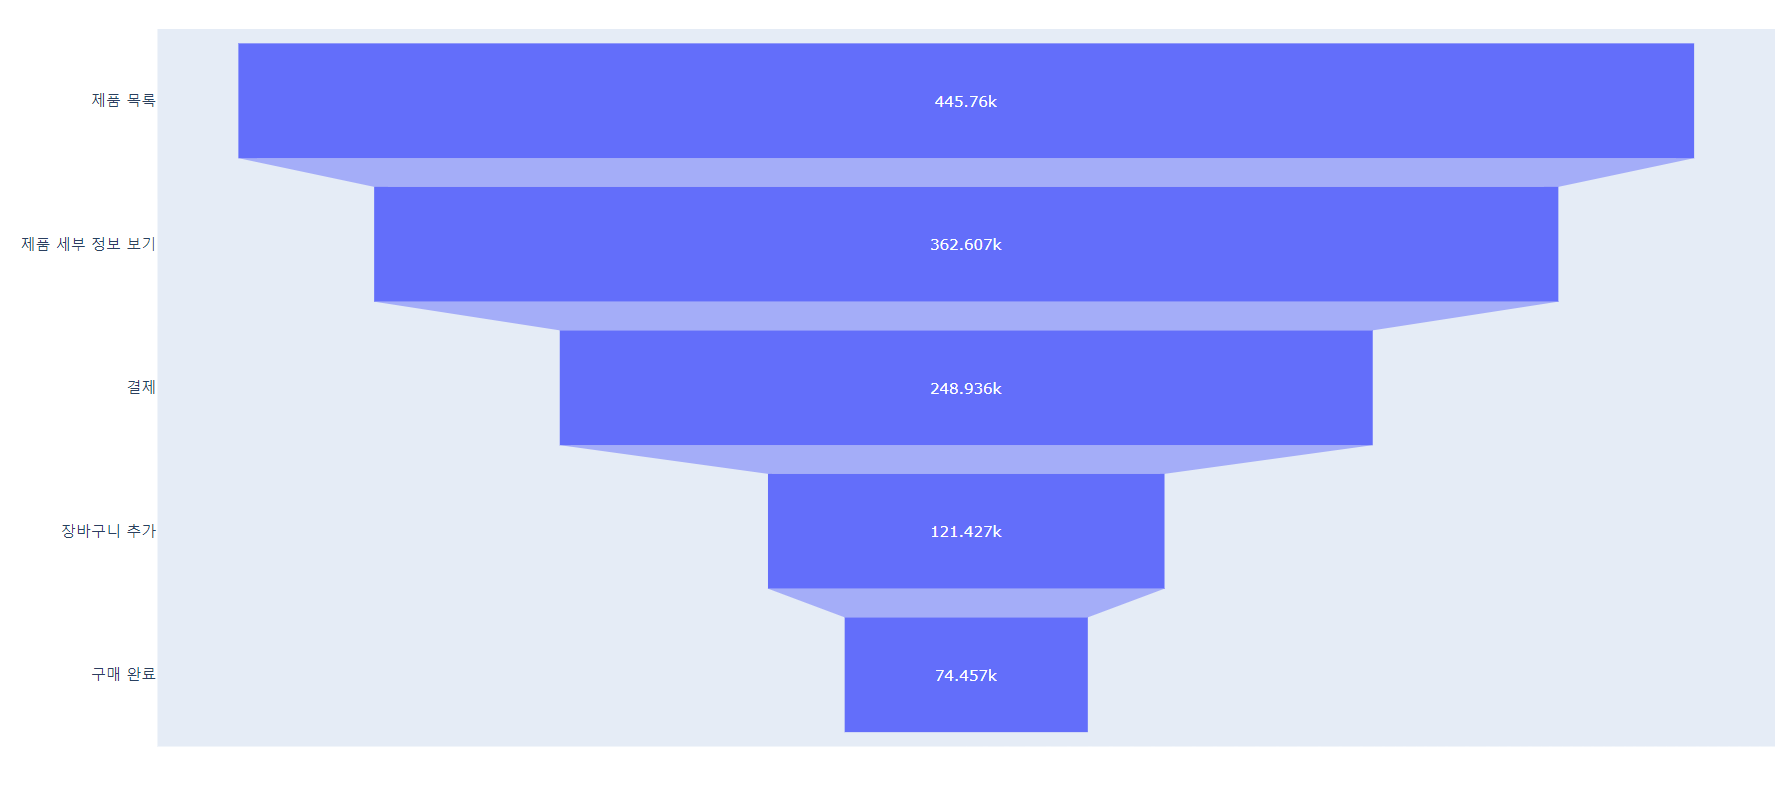

In [46]:
# 1610 퍼널 분석 
query = """
        SELECT 
            CASE WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
                 WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
                 WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
                 WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
            END AS action,
            COUNT(fullVisitorID) AS users,
        FROM 
            `bigquery-public-data.google_analytics_sample.ga_sessions_201610*`,
            UNNEST(hits) AS hits, 
            UNNEST(hits.product) AS product
        WHERE 
            hits.eCommerceAction.action_type != '0'  AND
            hits.eCommerceAction.action_type != '4'  AND
            hits.eCommerceAction.action_type != '3'
        GROUP BY 
            action
        ORDER BY 
            users DESC
        """

octo_result = client.query(query).result().to_dataframe()


data = dict(
    number = octo_result['users'],
    stage = octo_result['action']
)

# Plotly Express를 사용하여 퍼널 그래프 생성
funnel_graph = px.funnel(data, x='number', y='stage')
pyo.plot(funnel_graph, filename='funnel_graph_1610.html', auto_open=True)


'funnel_graph_1610.html'

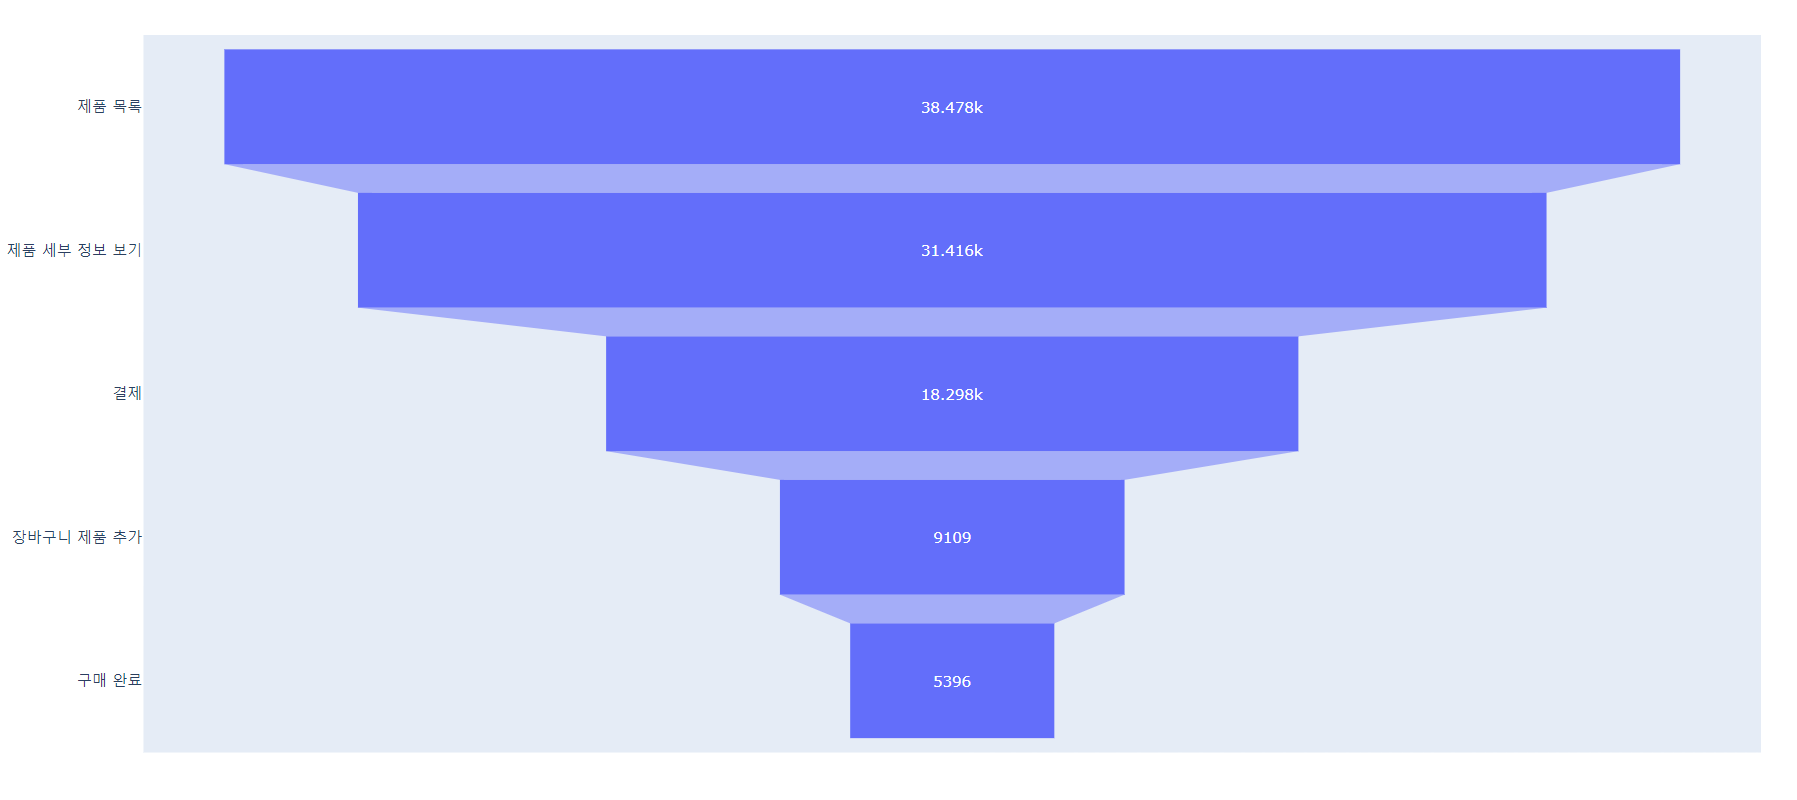

In [48]:
# 전체 전환율 계산
conversion_rates = [data['users'][i+1] / data['users'][i] * 100 if i+1 < len(data) else 0 for i in range(len(data))]
data['conversion_rate'] = conversion_rates
data

KeyError: 'users'

In [59]:
# 1610 전환율 계산 
conversion_rates = [octo_result['users'][i+1] / octo_result['users'][i] * 100 if i+1 < len(octo_result) else 0 for i in range(len(octo_result))]
octo_result['conversion_rate'] = conversion_rates
octo_result

action  users  conversion_rate
0        제품 목록  38478        81.646655
1  제품 세부 정보 보기  31416        58.244207
2           결제  18298        49.781397
3   장바구니 제품 추가   9109        59.238116
4        구매 완료   5396         0.000000

## 2-1. 코호트별 전환율 (사용자 기준) 확인 - fullvisitorid 사용 

더 해봐야 하는 것

- 특정 이벤트 경험 유무에 따라 결제 전환유무에 따라 결제 전환율에 차이가 있는가?
- 인구통계학적 정보에 따라 결제 전환율에 차이가 있는가? (ex 대륙)

#### 1) medium별 코호트에 따른 전환율

In [79]:
# 각 트래픽 소스별 결제 전환율 확인

query = """
SELECT 
    trafficSource.medium,
    CASE WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
         WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
         WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
         WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_201611*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
GROUP BY 
    trafficSource.medium,
    action
ORDER BY 
    trafficSource.medium, users DESC

"""

medium_result = client.query(query).result().to_dataframe()


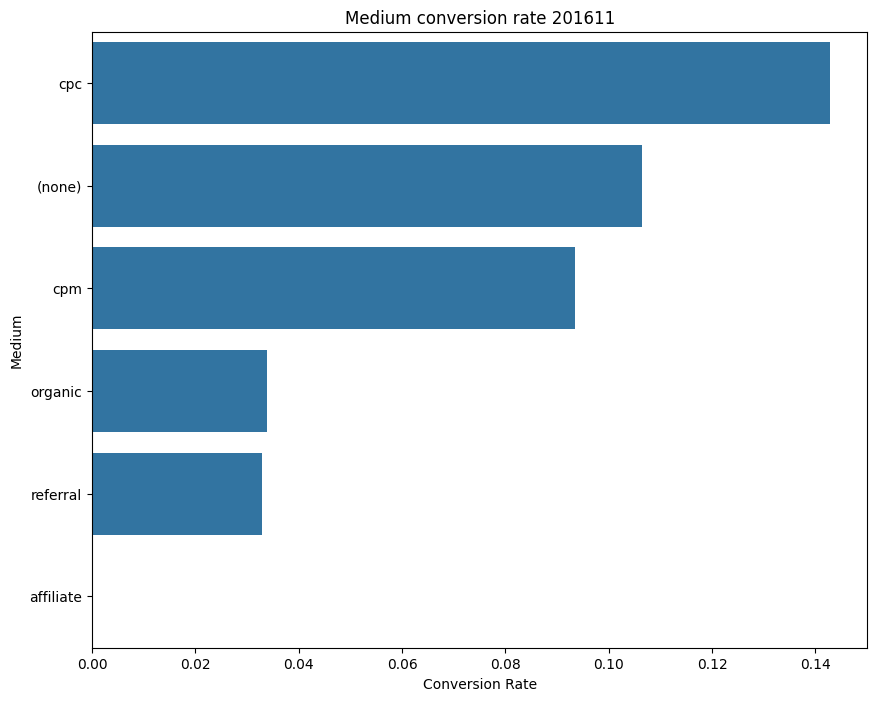

In [106]:
funnel_df = medium_result.pivot(index='medium', columns='action', values='users').reset_index()

# 전환율 계산 ('제품 목록' 대비 '구매 완료' 비율)
funnel_df['conversion_rate'] = funnel_df['구매 완료'] / funnel_df['제품 목록']

# 퍼널 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='conversion_rate', y='medium', data=funnel_df.sort_values('conversion_rate', ascending=False))
plt.title('Medium conversion rate 201611')
plt.xlabel('Conversion Rate')
plt.ylabel('Medium')
plt.show()

affiliate: 제휴 마케팅 통해 유입된 트래픽

referral: 참조 트래픽. 사용자가 다른 웹사이트의 링크를 클릭해 도착한 경우. 제휴 마케팅과 비슷하나 비금전적

organic: 유기적 검색 결과

not set: 트래픽 소스 지정되지 않았거나 알 수 없는 경우

cpc(cost per click): 클릭당 비용. 유료 검색 광고를 통해 유입된 트래픽

cpm(cost per mile): 천 회 노출당 비용. 디스플레이/배너 광고 통해 유입. 광고 노출 횟수에 따라 비용 청구 = 사용자가 광고 클릭해 웹사이트에 도달한 경우

none: 직접 트래픽. 사용자가 브라우저에 url 직접 입력하거나 북마크 통해 웹사이트 도달한 경우 의미. 

In [82]:
# 통계 검정
from scipy.stats import chi2_contingency

# '제품 목록' 대비 '구매 완료' 사용자 수를 카운트하여 테이블 생성
conversion_table = funnel_df[['medium', '제품 목록', '구매 완료']]

# 각 medium 별로 '제품 목록' 대비 '구매 완료' 비율의 차이가 통계적으로 유의미한지 검증할 준비
# 카이제곱 검정을 위한 테이블 형태로 데이터를 조정 (예: 구매 완료 vs. 구매 완료 아닌 경우)
conversion_table['not_converted'] = conversion_table['제품 목록'] - conversion_table['구매 완료']
chi2_test_data = conversion_table[['구매 완료', 'not_converted']].values

# 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(chi2_test_data)

chi2, p

C:\Users\USER\AppData\Local\Temp\ipykernel_21608\238734123.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



TypeError: boolean value of NA is ambiguous

medium에 따른 구매 전환율에 차이가 있음. 그리고 pvalue가 0.05 미만이므로 각 medium이 구매 전환율에 미치는 영향이 통계적으로 유의함. 

In [76]:
# 월별 코호트별 전환율 파악 


query = """
SELECT 
    trafficSource.medium,
    FORMAT_DATE("%Y%m", PARSE_DATE("%Y%m%d", _TABLE_SUFFIX)) AS YearMonth,
    CASE WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
         WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
         WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
         WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
GROUP BY 
    trafficSource.medium,
    action,
    YearMonth
ORDER BY 
    trafficSource.medium, users DESC

"""

monthly_medium_result = client.query(query).result().to_dataframe()


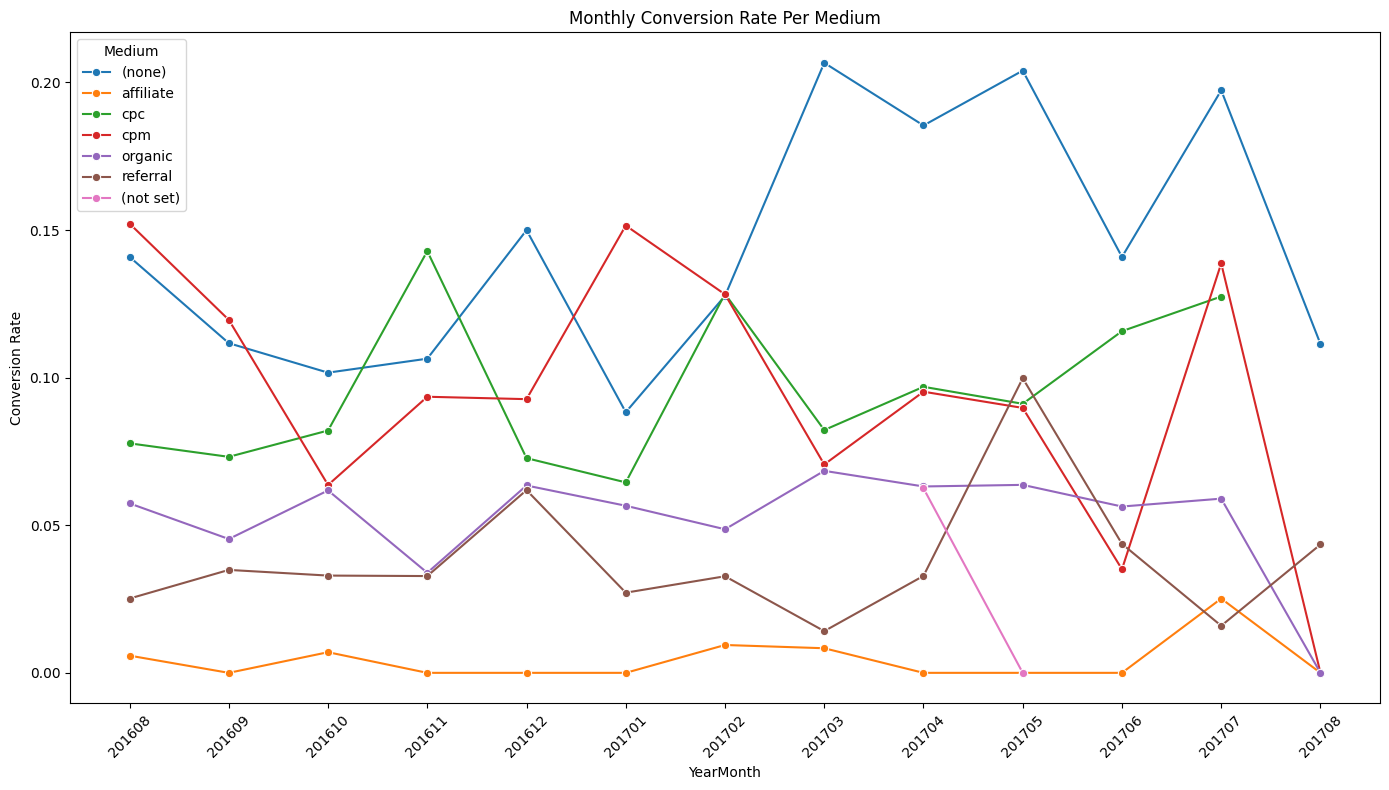

In [9]:
# 전환율 계산을 위해 pivot_table을 생성
pivot_df = monthly_medium_result.pivot_table(index=['YearMonth', 'medium'], columns='action', values='users', aggfunc='sum', fill_value=0).reset_index()

# '구매 완료' / '제품 목록'으로 전환율 계산
pivot_df['ConversionRate'] = pivot_df['구매 완료'] / pivot_df['제품 목록']

# 시각화
plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_df, x='YearMonth', y='ConversionRate', hue='medium', marker='o')
plt.title('Monthly Conversion Rate Per Medium')
plt.xlabel('YearMonth')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.legend(title='Medium')
plt.tight_layout()
plt.show()

확실히 직접 검색해서 전환된 사람들의 비율이 높음. 그다음이 유료 광고

그렇다면 결제 전환이 되지 않은 고객의 경우는 어떠한가?

In [84]:
# 전환 안 된 고객들의 유입 매체 확인

conversion_table.fillna(0, inplace = True)

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(conversion_table['medium'], conversion_table['not_converted'], color='skyblue')
plt.title('Non-Converted Users by Medium')
plt.xlabel('Medium')
plt.ylabel('Number of Non-Converted Users')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_21608\2521303672.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



근데 여기서 none은 unknown이랑 다른 거겠지? 

#### 2) 캠페인별 코호트 

In [86]:
# 월별 코호트별 전환율 파악 


query = """
SELECT 
    trafficSource.campaign AS Campaign,
    FORMAT_DATE("%Y%m", PARSE_DATE("%Y%m%d", _TABLE_SUFFIX)) AS YearMonth,
    CASE WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
         WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
         WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
         WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
GROUP BY 
    Campaign,
    action,
    YearMonth
ORDER BY 
    Campaign, users DESC

"""

monthly_cam_result = client.query(query).result().to_dataframe()


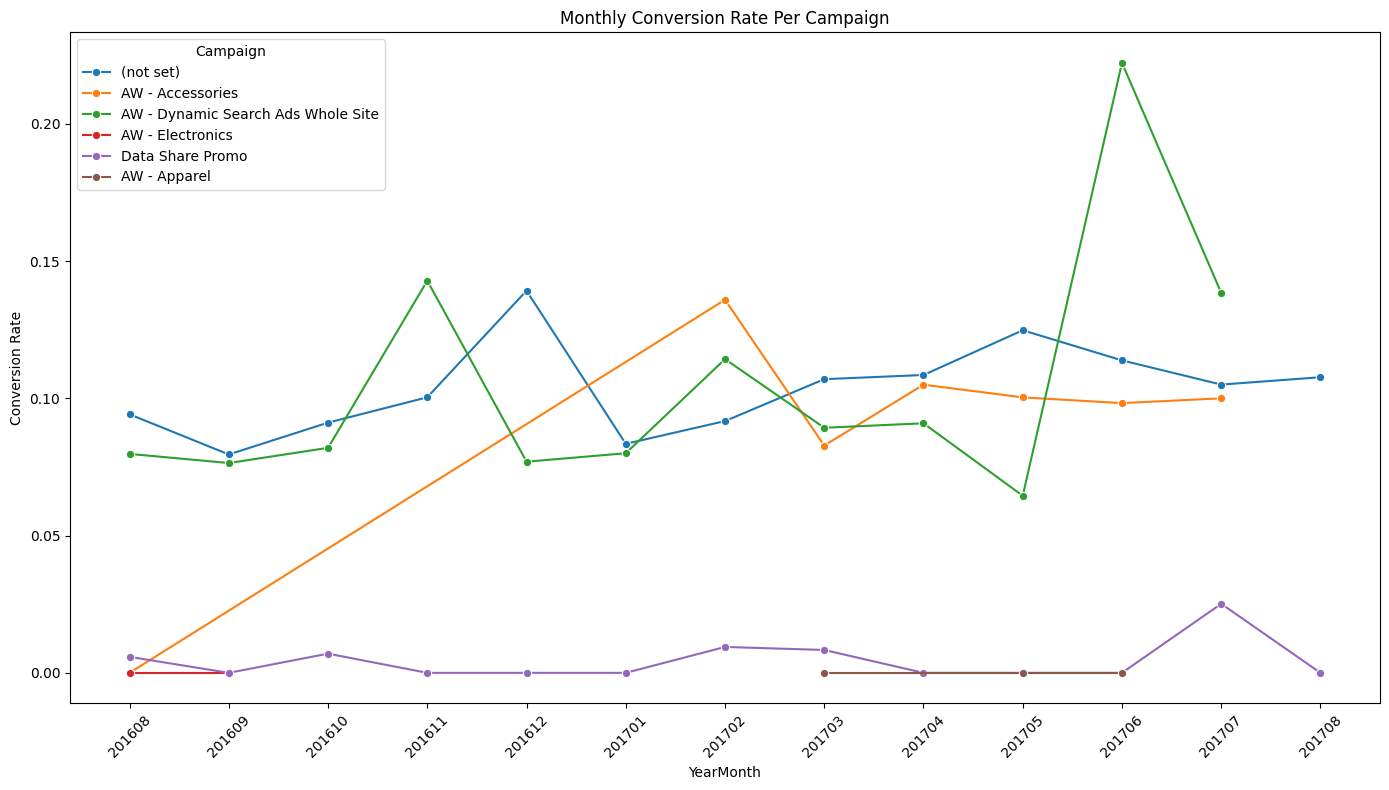

In [87]:
# 전환율 계산을 위해 pivot_table을 생성
pivot_df = monthly_cam_result.pivot_table(index=['YearMonth', 'Campaign'], columns='action', values='users', aggfunc='sum', fill_value=0).reset_index()

# '구매 완료' / '제품 목록'으로 전환율 계산
pivot_df['ConversionRate'] = pivot_df['구매 완료'] / pivot_df['제품 목록']

# 시각화
plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_df, x='YearMonth', y='ConversionRate', hue='Campaign', marker='o')
plt.title('Monthly Conversion Rate Per Campaign')
plt.xlabel('YearMonth')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.legend(title='Campaign')
plt.tight_layout()
plt.show()

In [97]:

# 퍼널 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='conversion_rate', y='Campaign', data=pivot_df.sort_values('conversion_rate', ascending=False))
plt.title('Campaign conversion rate 201611')
plt.xlabel('Conversion Rate')
plt.ylabel('Campaign')
plt.show()

In [95]:
# 전환 안 된 고객들의 유입 매체 확인
# 전환되지 않은 사용자
# '제품 목록' 대비 '구매 완료' 사용자 수를 카운트하여 테이블 생성
conversion_table_cam = pivot_df[['Campaign', '제품 목록', '구매 완료']]
conversion_table_cam['not_converted'] = conversion_table_cam['제품 목록'] - conversion_table_cam['구매 완료']
conversion_table_cam.fillna(0, inplace = True)

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(conversion_table_cam['Campaign'], conversion_table_cam['not_converted'], color='skyblue')
plt.title('Non-Converted Users by Campaign')
plt.xlabel('Campaign')
plt.ylabel('Number of Non-Converted Users')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_21608\1562912570.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### 3) 소스별 코호트 

In [98]:

# 월별 코호트별 전환율 파악 


query = """
SELECT 
    trafficSource.source AS Source,
    FORMAT_DATE("%Y%m", PARSE_DATE("%Y%m%d", _TABLE_SUFFIX)) AS YearMonth,
    CASE WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
         WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
         WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
         WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
GROUP BY 
    Source,
    action,
    YearMonth
ORDER BY 
    Source, users DESC

"""

monthly_sor_result = client.query(query).result().to_dataframe()


In [99]:
# 전환율 계산을 위해 pivot_table을 생성
pivot_df = monthly_sor_result.pivot_table(index=['YearMonth', 'Source'], columns='action', values='users', aggfunc='sum', fill_value=0).reset_index()

# '구매 완료' / '제품 목록'으로 전환율 계산
pivot_df['ConversionRate'] = pivot_df['구매 완료'] / pivot_df['제품 목록']

# 시각화
plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_df, x='YearMonth', y='ConversionRate', hue='Source', marker='o')
plt.title('Monthly Conversion Rate Per Source')
plt.xlabel('YearMonth')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.legend(title='Source')
plt.tight_layout()
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_21608\646977477.py:15: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.



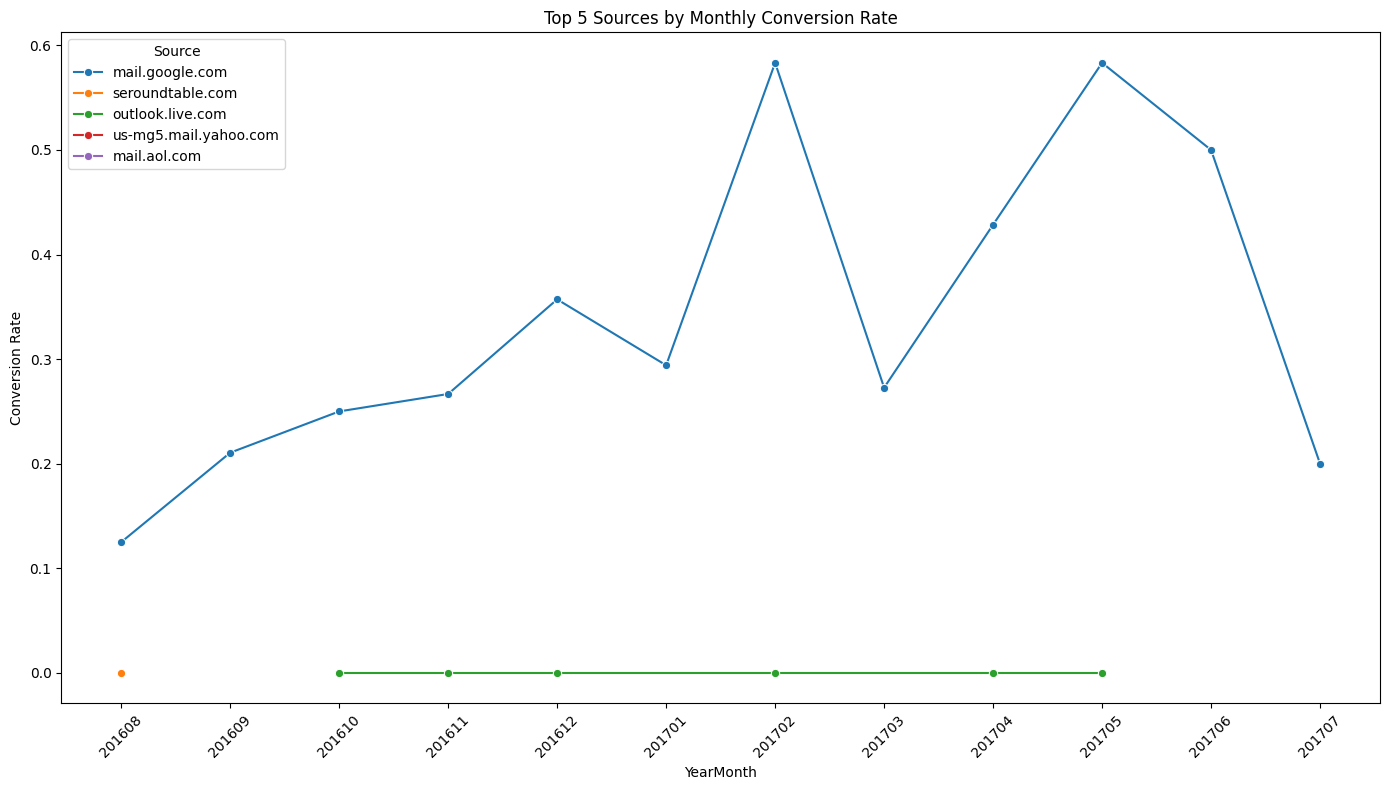

In [111]:
# 전환율 계산을 위해 pivot_table을 생성
pivot_df = monthly_sor_result.pivot_table(
    index=['YearMonth', 'Source'], 
    columns='action', 
    values='users', 
    aggfunc='mean', 
    fill_value=0
).reset_index()

# '구매 완료' / '제품 목록'으로 전환율 계산
pivot_df['ConversionRate'] = pivot_df['구매 완료'] / pivot_df['제품 목록']

# 각 소스별로 가장 높은 전환율을 가진 월을 찾아서 상위 5개 소스를 결정
top_sources = pivot_df.groupby('Source')['ConversionRate'].max().sort_values(ascending=False).head(5).index

# 상위 5개 소스만 필터링
top_pivot_df = pivot_df[pivot_df['Source'].isin(top_sources)]

# 시각화
plt.figure(figsize=(14, 8))
sns.lineplot(data=top_pivot_df, x='YearMonth', y='ConversionRate', hue='Source', marker='o')
plt.title('Top 5 Sources by Monthly Conversion Rate')
plt.xlabel('YearMonth')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.legend(title='Source')
plt.tight_layout()
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_21608\445095980.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\USER\AppData\Local\Temp\ipykernel_21608\445095980.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



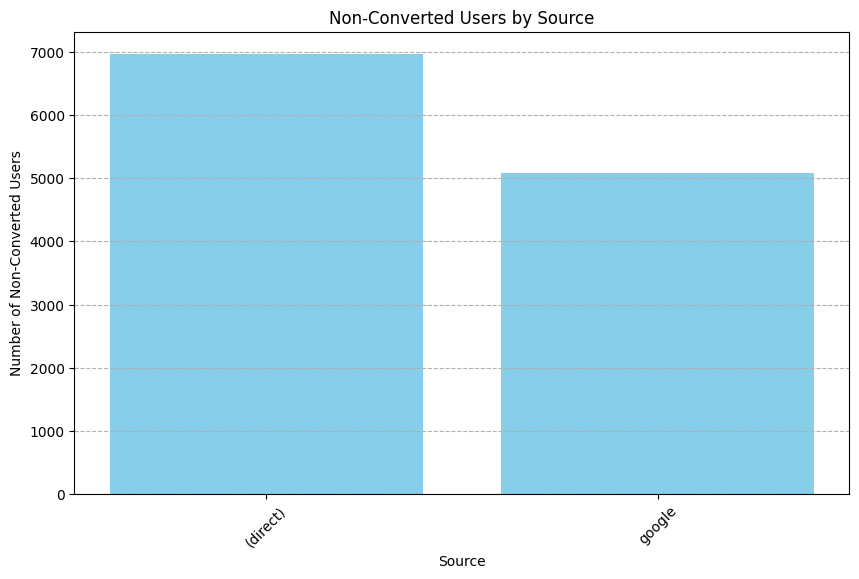

In [112]:
# 미전환 유저

# 전환 안 된 고객들의 유입 매체 확인
# 전환되지 않은 사용자
# '제품 목록' 대비 '구매 완료' 사용자 수를 카운트하여 테이블 생성
conversion_table_sor = pivot_df[['Source', '제품 목록', '구매 완료']]
conversion_table_sor['not_converted'] = conversion_table_sor['제품 목록'] - conversion_table_sor['구매 완료']
conversion_table_sor.fillna(0, inplace = True)

# 전환되지 않은 사용자 수가 많은 상위 5개 유입 매체 추출
top_5_sources = conversion_table_sor.sort_values('not_converted', ascending=False).head(5)

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(top_5_sources['Source'], top_5_sources['not_converted'], color='skyblue')
plt.title('Non-Converted Users by Source')
plt.xlabel('Source')
plt.ylabel('Number of Non-Converted Users')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

#### 4) 광고별 코호트 

In [107]:

# 월별 코호트별 전환율 파악 


query = """
SELECT 
    trafficSource.adContent AS AdContent,
    FORMAT_DATE("%Y%m", PARSE_DATE("%Y%m%d", _TABLE_SUFFIX)) AS YearMonth,
    CASE WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
         WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
         WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
         WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
GROUP BY 
    AdContent,
    action,
    YearMonth
ORDER BY 
    AdContent, users DESC

"""

monthly_ad_result = client.query(query).result().to_dataframe()


In [114]:
# 전환율 계산을 위해 pivot_table을 생성
pivot_df = monthly_ad_result.pivot_table(index=['YearMonth', 'AdContent'], columns='action', values='users', aggfunc='sum', fill_value=0).reset_index()

# '구매 완료' / '제품 목록'으로 전환율 계산
pivot_df['ConversionRate'] = pivot_df['구매 완료'] / pivot_df['제품 목록']

# 시각화
plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_df, x='YearMonth', y='ConversionRate', hue='AdContent', marker='o')
plt.title('Monthly Conversion Rate Per AdContent')
plt.xlabel('YearMonth')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.legend(title='AdContent')
plt.tight_layout()
plt.show()

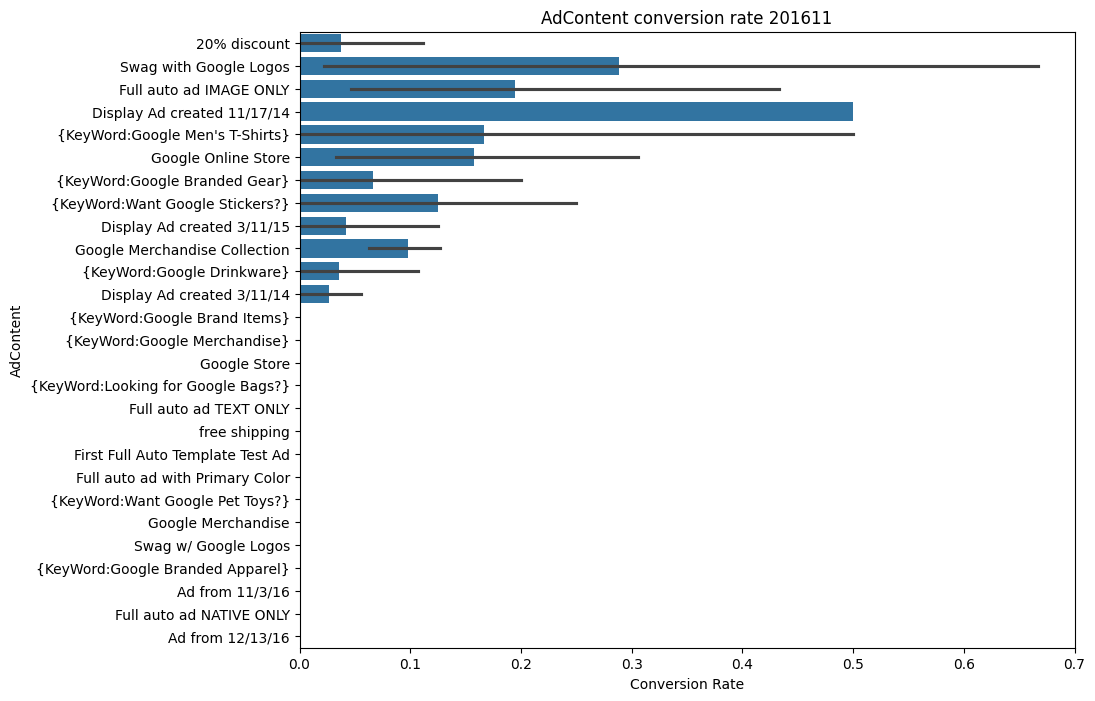

In [115]:
# 전환율 계산 ('제품 목록' 대비 '구매 완료' 비율)
pivot_df['conversion_rate'] = pivot_df['구매 완료'] / pivot_df['제품 목록']

# 퍼널 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='conversion_rate', y='AdContent', data=pivot_df.sort_values('conversion_rate', ascending=False))
plt.title('AdContent conversion rate 201611')
plt.xlabel('Conversion Rate')
plt.ylabel('AdContent')
plt.show()

In [118]:
# 미전환 고객 
conversion_table_ad = pivot_df[['AdContent', '제품 목록', '구매 완료']]
conversion_table_ad['not_converted'] = conversion_table_ad['제품 목록'] - conversion_table_ad['구매 완료']
conversion_table_ad.fillna(0, inplace = True)


# 시각화
plt.figure(figsize=(10, 6))
plt.bar(conversion_table_ad['AdContent'], conversion_table_ad['not_converted'], color='skyblue')
plt.title('Non-Converted Users by AdContent')
plt.xlabel('AdContent')
plt.ylabel('Number of Non-Converted Users')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_21608\2183549771.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\USER\AppData\Local\Temp\ipykernel_21608\2183549771.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### 5) 소셜 미디어 플랫폼별 코호트에 따른 전환율

In [56]:
# 소셜 미디어에서 세션으로 넘어온 유저들의 수와 비율
query = """
WITH ReferralStats AS (
  SELECT
    (SELECT COUNT(DISTINCT fullVisitorId) 
     FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`, 
     UNNEST(hits) AS hits 
     WHERE hits.social.hasSocialSourceReferral = 'Yes') AS socialReferralUsers,
    COUNT(DISTINCT fullVisitorId) AS totalUsers
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
)

SELECT
  socialReferralUsers,
  totalUsers,
  (socialReferralUsers * 100.0 / totalUsers) AS percentageOfSocialReferralUsers
FROM ReferralStats

"""
media_result = client.query(query).result().to_dataframe()

In [61]:
# hits.social.socialNetwork: 소셜 네크워크 이름. 트래픽 소스의 추천 소셜 네트워크와 관련
# 트래픽 소스의 추천 소셜 네트워크: 유저가 어떤 소셜 네트워크를 통해 웹사이트에 연결됐는지 나타내는 정보 
query = """
SELECT 
    hit.social.socialNetwork
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`, 
    UNNEST(hits) AS hit
WHERE 
    hit.social.socialNetwork IS NOT NULL
GROUP BY 
    hit.social.socialNetwork

"""

media_conv = client.query(query).result().to_dataframe()

media_conv

socialNetwork
0          Tumblr
1          reddit
2       Pinterest
3         YouTube
4         Twitter
5     Hacker News
6          Pocket
7            Digg
8   Google Groups
9       (not set)
10          Quora
11         Meetup
12       Facebook
13      VKontakte
14       LinkedIn
15        Google+

In [9]:
# 유입 소셜 네트워크별 전환율 비교: 전체 기간 

query = """
SELECT 
    hits.social.socialNetwork,
    CASE WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
         WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
         WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
         WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6') AND hits.social.socialNetwork IS NOT NULL
GROUP BY 
    hits.social.socialNetwork,
    action
ORDER BY 
    hits.social.socialNetwork, users DESC

"""

media_conv = client.query(query).result().to_dataframe()


In [37]:
funnel_df = media_conv.pivot(index='socialNetwork', columns='action', values='users').reset_index()

# 전환율 계산 ('제품 목록' 대비 '구매 완료' 비율)
funnel_df['conversion_rate'] = funnel_df['구매 완료'] / funnel_df['제품 목록']

# 퍼널 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='conversion_rate', y='socialNetwork', data=funnel_df.sort_values('conversion_rate', ascending=False))
plt.title('Social Media conversion rate 201608 ~ 201707')
plt.xlabel('Conversion Rate')
plt.ylabel('Social Media')
plt.show()

In [38]:
# '제품 목록' 대비 '구매 완료' 사용자 수를 카운트하여 테이블 생성
conversion_table = funnel_df[['socialNetwork', '제품 목록', '구매 완료']]
conversion_table.fillna(0, inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_26856\3127521398.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [39]:
conversion_table # 근데 확인 결과 거의 대부분이 미식별 유저이긴 함.. 

action  socialNetwork  제품 목록  구매 완료
0           (not set)  95075   9923
1                Digg      1      0
2            Facebook    705     36
3       Google Groups    115     37
4             Google+     74      5
5            LinkedIn      4      0
6           Pinterest      8      2
7              Pocket      2      0
8               Quora     56      1
9             Twitter     93      7
10          VKontakte     13      0
11            YouTube   3411     11
12             reddit    120      1

In [18]:
# 각 medium 별로 '제품 목록' 대비 '구매 완료' 비율의 차이가 통계적으로 유의미한지 검증할 준비
conversion_table['not_converted'] = conversion_table['제품 목록'] - conversion_table['구매 완료']
chi2_test_data = conversion_table[['구매 완료', 'not_converted']].values

# 검정 수행
chi2, p, dof, expected = chi2_contingency(chi2_test_data)

chi2, p

C:\Users\USER\AppData\Local\Temp\ipykernel_26856\2864148411.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(475.1493384166535, 4.2820276697568543e-94)

In [77]:
# 유입 소셜 네트워크별 전환율 비교: 201611

query = """
SELECT 
    hits.social.socialNetwork,
    CASE WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
         WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
         WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
         WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_201611*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6') AND hits.social.socialNetwork IS NOT NULL
GROUP BY 
    hits.social.socialNetwork,
    action
ORDER BY 
    hits.social.socialNetwork, users DESC

"""

media_conv = client.query(query).result().to_dataframe()


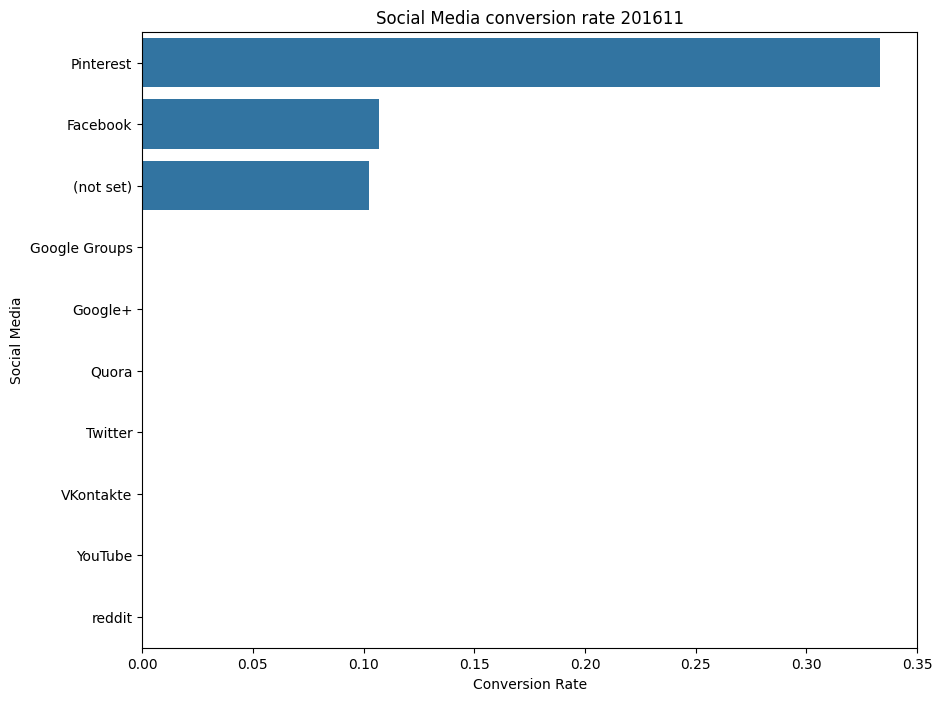

In [78]:
funnel_df = media_conv.pivot(index='socialNetwork', columns='action', values='users').reset_index()

# 전환율 계산 ('제품 목록' 대비 '구매 완료' 비율)
funnel_df['conversion_rate'] = funnel_df['구매 완료'] / funnel_df['제품 목록']

# 퍼널 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='conversion_rate', y='socialNetwork', data=funnel_df.sort_values('conversion_rate', ascending=False))
plt.title('Social Media conversion rate 201611')
plt.xlabel('Conversion Rate')
plt.ylabel('Social Media')
plt.show()

In [11]:
# 월별 코호트별 전환율 파악 

query = """
SELECT 
    hits.social.socialNetwork,
    FORMAT_DATE("%Y%m", PARSE_DATE("%Y%m%d", _TABLE_SUFFIX)) AS YearMonth,
    CASE WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
         WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
         WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
         WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
GROUP BY 
    hits.social.socialNetwork,
    action,
    YearMonth
ORDER BY 
    users DESC

"""

monthly_media_result = client.query(query).result().to_dataframe()


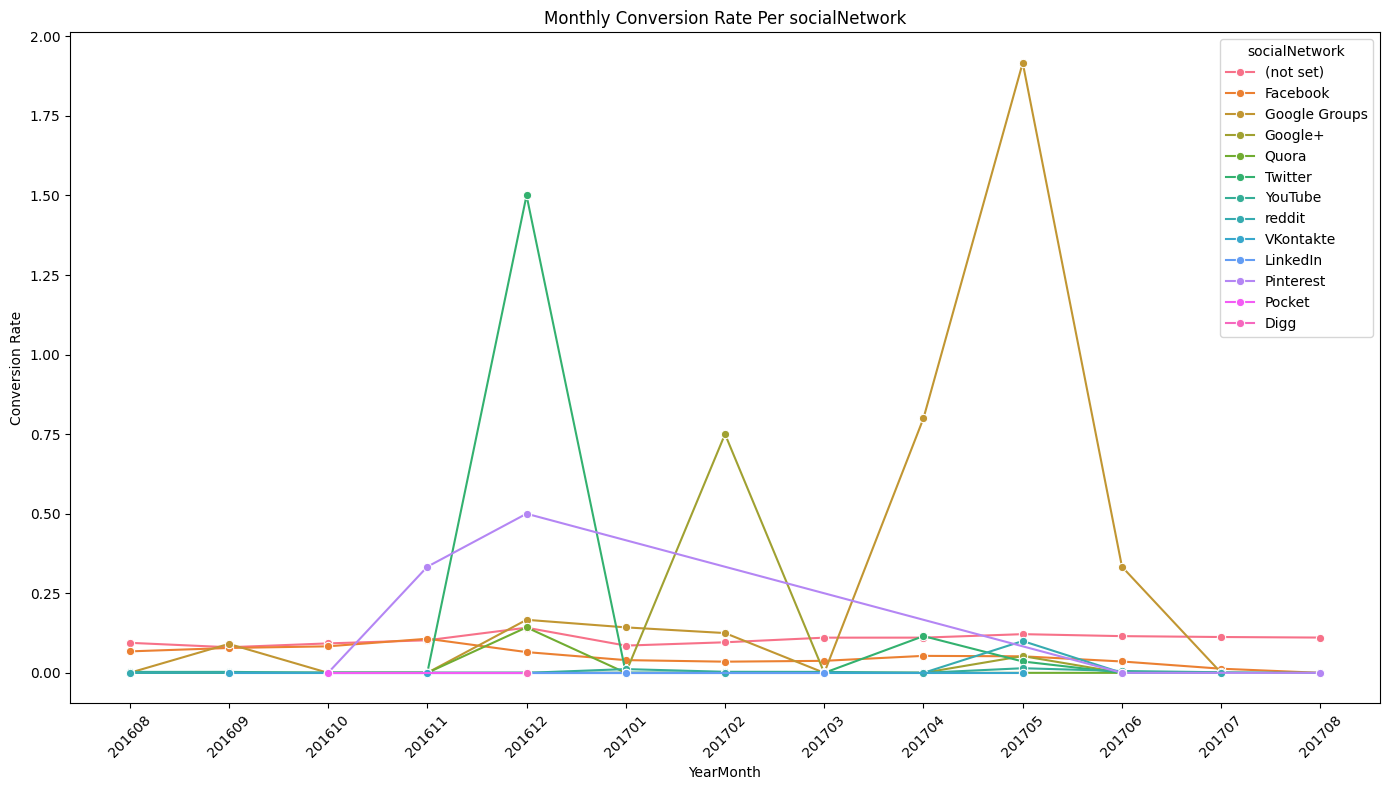

In [14]:
# 전환율 계산을 위해 pivot_table을 생성
pivot_df = monthly_media_result.pivot_table(index=['YearMonth', 'socialNetwork'], columns='action', values='users', aggfunc='sum', fill_value=0).reset_index()

# '구매 완료' / '제품 목록'으로 전환율 계산
pivot_df['ConversionRate'] = pivot_df['구매 완료'] / pivot_df['제품 목록']

# 시각화
plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_df, x='YearMonth', y='ConversionRate', hue='socialNetwork', marker='o')
plt.title('Monthly Conversion Rate Per socialNetwork')
plt.xlabel('YearMonth')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.legend(title='socialNetwork')
plt.tight_layout()
plt.show()

실질적인 구매로 이뤄지는 미디어는 ㅇㅇㅇㅇ 정도이다.

#### 6) 요일별 전환율 비교

In [109]:
# 요일별 코호트에 따른 전환율 

query = """
SELECT 
    EXTRACT(DAYOFWEEK FROM PARSE_DATE('%Y%m%d', Date)) AS DayOfWeek,
    CASE 
        WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
        WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
        WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
        WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
GROUP BY 
    DayOfWeek,
    action
ORDER BY 
    DayOfWeek, users DESC
"""



day_conv = client.query(query).result().to_dataframe()


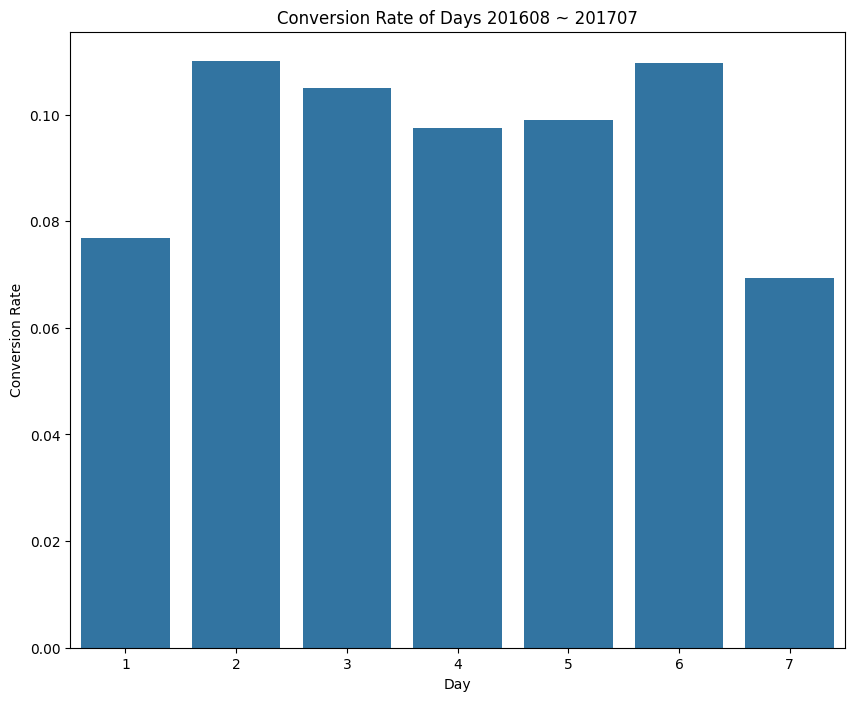

In [ ]:
day_funnel_df = day_conv.pivot(index='DayOfWeek', columns='action', values='users').reset_index()

# 전환율 계산 ('제품 목록' 대비 '구매 완료' 비율)
day_funnel_df['conversion_rate'] = day_funnel_df['구매 완료'] / day_funnel_df['제품 목록']

# 퍼널 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='DayOfWeek', y='conversion_rate', data=day_funnel_df.sort_values('conversion_rate', ascending=False))
plt.title('Conversion Rate of Days 201608 ~ 201707')
plt.xlabel('Day')
plt.ylabel('Conversion Rate')
plt.show()

In [125]:
# 위에선 크게 알 수 있는 게 없으니 전체 기간 별로 어떤지 확인해보자 
query = """
SELECT 
    EXTRACT(DAYOFWEEK FROM PARSE_DATE('%Y%m%d', date)) AS DayOfWeek,
    FORMAT_DATE("%Y%m", PARSE_DATE('%Y%m%d', date)) AS YearMonth,
    CASE 
        WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
        WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
        WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
        WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS Action,
    COUNT(DISTINCT fullVisitorID) AS Users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
GROUP BY 
    DayOfWeek, YearMonth, Action
ORDER BY 
    YearMonth, DayOfWeek, Action

"""

weekly_conv = client.query(query).result().to_dataframe()


In [126]:
filtered_df = weekly_conv[weekly_conv['Action'].isin(['제품 목록', '구매 완료'])]

# 전환율 계산을 위해 pivot_table 생성
pivot_df = filtered_df.pivot_table(index=['YearMonth', 'DayOfWeek'], columns='Action', values='Users', aggfunc='sum').reset_index()

# '구매 완료' 사용자 수를 '제품 목록' 사용자 수로 나누어 전환율 계산
pivot_df['ConversionRate'] = pivot_df['구매 완료'] / pivot_df['제품 목록']

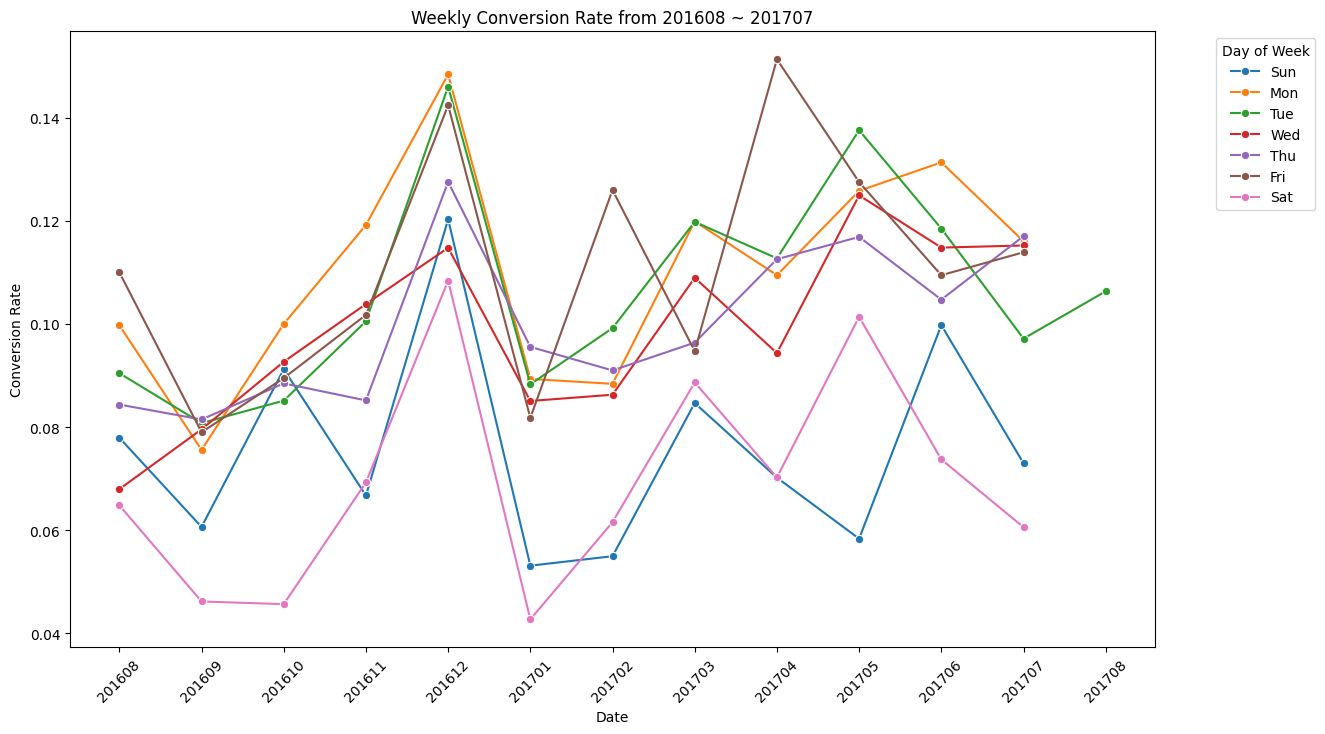

In [127]:
day_names = {1: 'Sun', 2: 'Mon', 3: 'Tue', 4: 'Wed', 5: 'Thu', 6: 'Fri', 7: 'Sat'}
pivot_df['DayOfWeekName'] = pivot_df['DayOfWeek'].map(day_names)

# 시각화에 DayOfWeekName을 사용
plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_df, x='YearMonth', y='ConversionRate', hue='DayOfWeekName', marker='o', palette='tab10')
plt.title('Weekly Conversion Rate from 201608 ~ 201707')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.legend(title='Day of Week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

* 평일, 특히 월요일은 전환률이 전반적으로 높은 것 같고 주말은 전반적으로 전환률 낮음 이거 외에는 또 뭐를 알 수가 있지... 



* 보면 제품 목록 -> 제품 상세 목록은 다들 잘 넘어감 근데 제품 상세 목록 -> 결제에서 0.3 정도만 들어오고 결제 -> 구매 완료까지 또 0.3 정도만 남음 

* mau를 보면 1611에서 최고점 찍고 1611 - 1612 구간에서 폭락함.
-> nau 보니 신규 유저는 1611에 최고치. 그러다 1612에는 평소 신규 유저 수 정도로 돌아옴. 
-> mau는 신규 유저가 유입이 그때 많이 돼서 최고점이었던듯 

전환률은 1612가 최고지점.
신규 유저 수는 전달에 비해 줄었지만(평소대로 돌아왔으나) 유저들의 전환률은 올라갔다? 왜 올라갔지 기존 유저들의 구매 전환율이 확 튀었나? 

우선 신규 유저들의 전환률을 확인해보자. 


#### 7) 유저 코호트별 전환률 



* 기존 유저

* 신규 유저 

* 백롤링? 유저 

In [137]:
# 신규 유저들의 전환률

query = """
SELECT 
    FORMAT_DATE("%Y%m", PARSE_DATE('%Y%m%d', date)) AS YearMonth,
    CASE 
        WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
        WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
        WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
        WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS Action,
    COUNT(DISTINCT fullVisitorID) AS NewUsers
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
WHERE 
    totals.newVisits = 1 AND
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
GROUP BY 
    YearMonth, Action
ORDER BY 
    YearMonth, Action

"""

new_user_conv_rate = client.query(query).result().to_dataframe()

In [142]:
filtered_df = new_user_conv_rate[new_user_conv_rate['Action'].isin(['제품 목록', '구매 완료'])]

# 전환율 계산을 위해 pivot_table 생성
pivot_df = filtered_df.pivot_table(index=['YearMonth'], columns='Action', values='NewUsers', aggfunc='sum').reset_index()

# '구매 완료' 사용자 수를 '제품 목록' 사용자 수로 나누어 전환율 계산
pivot_df['ConversionRate'] = pivot_df['구매 완료'] / pivot_df['제품 목록']

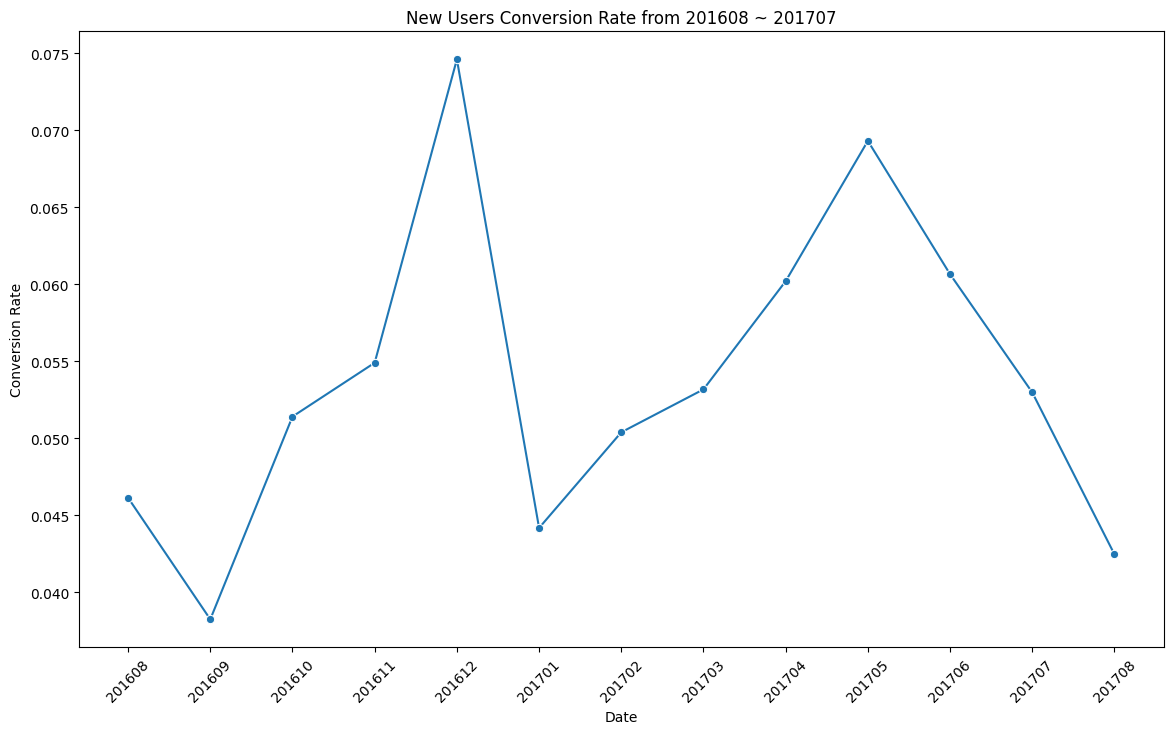

In [145]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_df, x='YearMonth', y='ConversionRate', marker='o')
plt.title('New Users Conversion Rate from 201608 ~ 201707')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.show()

In [150]:
# 기존 유저들의 전환률 

query = """
SELECT 
    FORMAT_DATE("%Y%m", PARSE_DATE('%Y%m%d', date)) AS YearMonth,
    CASE 
        WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
        WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
        WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
        WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS Action,
    COUNT(DISTINCT fullVisitorID) AS OldUsers
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
WHERE 
    totals.newVisits IS NULL AND
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
GROUP BY 
    YearMonth, Action
ORDER BY 
    YearMonth, Action

"""
old_user_conv_rate = client.query(query).result().to_dataframe()

In [152]:
filtered_df = old_user_conv_rate[old_user_conv_rate['Action'].isin(['제품 목록', '구매 완료'])]

# 전환율 계산을 위해 pivot_table 생성
pivot_df = filtered_df.pivot_table(index=['YearMonth'], columns='Action', values='OldUsers', aggfunc='sum').reset_index()

# '구매 완료' 사용자 수를 '제품 목록' 사용자 수로 나누어 전환율 계산
pivot_df['ConversionRate'] = pivot_df['구매 완료'] / pivot_df['제품 목록']

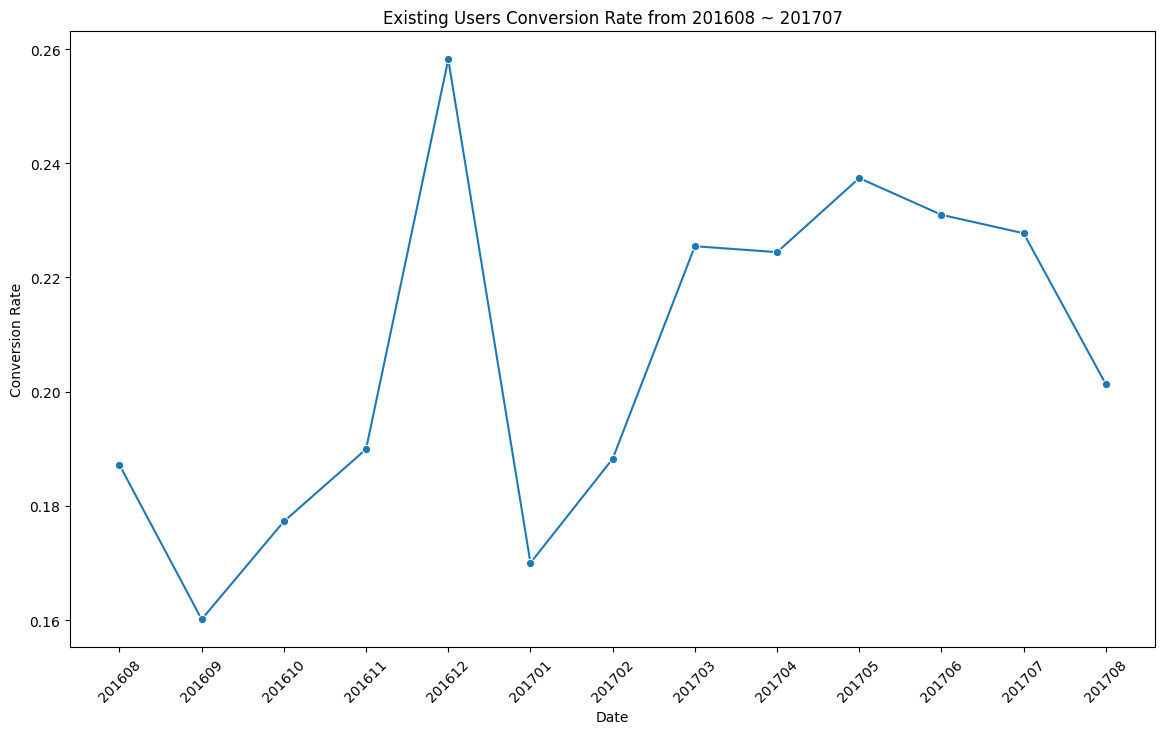

In [153]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_df, x='YearMonth', y='ConversionRate', marker='o')
plt.title('Existing Users Conversion Rate from 201608 ~ 201707')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.show()

확인해 보니 기존 유저 / 신규 유저 코호트 모두 1612에 가장 높은 전환률을 가지지만

일단 기존 유저들의 전환률이 평균적으로 신규 유저들 보다 4배 이상 높음

아무튼 신규/기존과는 증가한 전환률이 관련 없는듯 

- 프로모션이나 이런 거 확인해보자 

- 그리고 신규 유저 전환률은 왜 이렇게 낮은 거지? exiting screen 확인해보자 



In [161]:
# 신규 유저들이 어디서 이탈하는지 확인해보자 

# hits.appInfo.landingScreenName: 세션의 방문 화면
# 아니 근데 이건 앱 정보 아닌가?
query = """
WITH first_visits AS (
  SELECT
    fullVisitorId,
    (SELECT hits.appInfo.exitScreenName FROM UNNEST(hits) hits WHERE hits.type='PAGE' AND hits.isEntrance IS TRUE LIMIT 1) AS exitingScreenName
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    totals.newVisits = 1
)

SELECT
  exitingScreenName,
  COUNT(fullVisitorId) AS new_users
FROM
  first_visits
GROUP BY
  exitingScreenName
ORDER BY
  new_users DESC
"""

new_exit_result = client.query(query).result().to_dataframe()




C:\Users\USER\AppData\Local\Temp\ipykernel_26856\2992256695.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




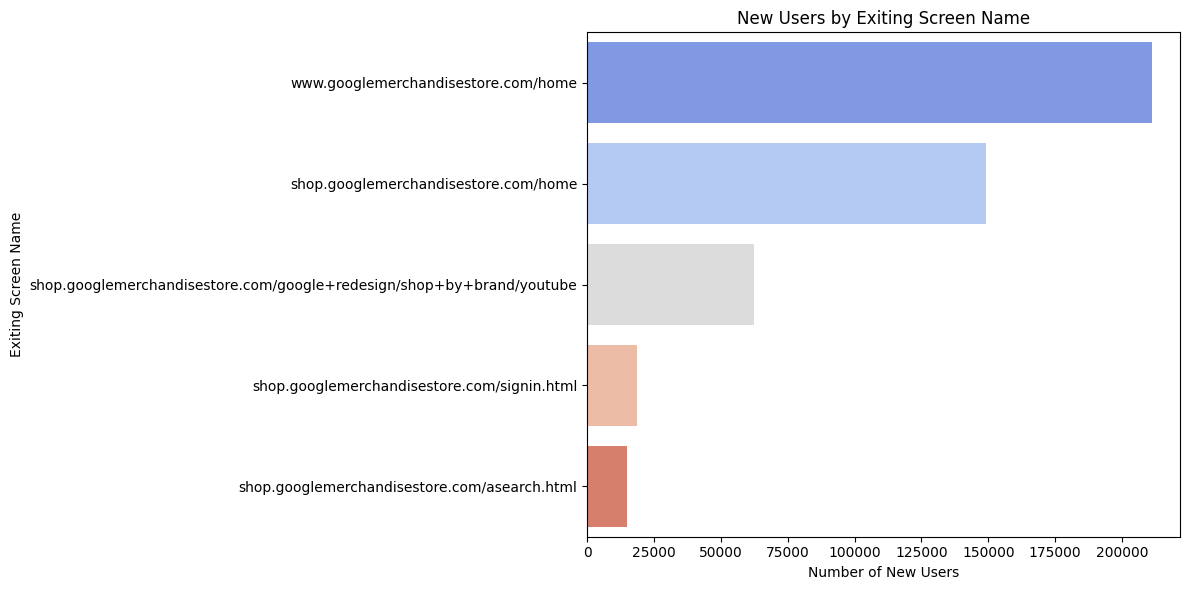

In [162]:
top5_exiting_pages = new_exit_result.sort_values('new_users', ascending=False).head(5)

# 막대 그래프 생성
plt.figure(figsize=(12, 6))  # 그래프 크기 조정
sns.barplot(x='new_users', y='exitingScreenName', data=top5_exiting_pages, palette='coolwarm')  # y축에 exitingScreenName을 사용하여 가로 막대 그래프 생성

# 그래프 제목과 축 라벨 추가
plt.title('New Users by Exiting Screen Name')
plt.xlabel('Number of New Users')
plt.ylabel('Exiting Screen Name')

# 그래프 표시
plt.tight_layout()
plt.show()

왜 들어오자마자 나감 

#### 8) 기기 코호트별 전환율 

In [54]:
# 사용 기기별 전환율 
query = """
SELECT 
    device.deviceCategory AS Device,
    CASE 
        WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
        WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
        WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
        WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
GROUP BY 
    Device,
    action
ORDER BY 
    Device, users DESC
"""

device_conv = client.query(query).result().to_dataframe()

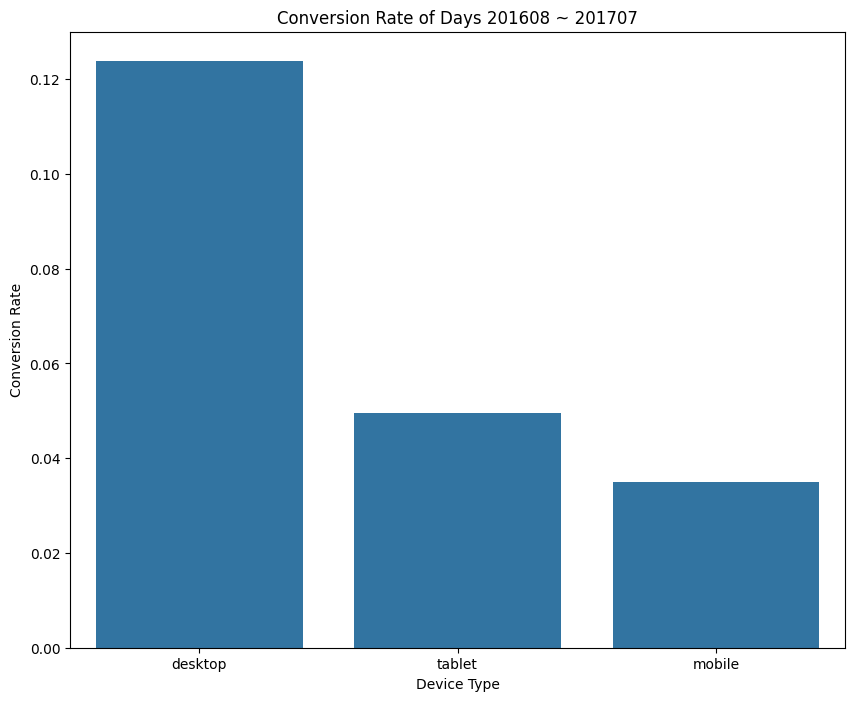

In [56]:
# 전환율 계산 ('제품 목록' 대비 '구매 완료' 비율)
device_funnel_df = device_conv.pivot(index='Device', columns='action', values='users').reset_index()
device_funnel_df['conversion_rate'] = device_funnel_df['구매 완료'] / device_funnel_df['제품 목록']

# 퍼널 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Device', y='conversion_rate', data=device_funnel_df.sort_values('conversion_rate', ascending=False))
plt.title('Conversion Rate of Days 201608 ~ 201707')
plt.xlabel('Device Type')
plt.ylabel('Conversion Rate')
plt.show()

In [60]:
device_funnel_df


action   Device     결제  구매 완료  제품 목록  제품 세부 정보 보기  conversion_rate
0       desktop  15488   9049  73076        72927          0.12383
1        mobile   2450    812  23199        23102         0.035002
2        tablet    341    160   3227         3227         0.049582

- desktop으로 유입되는 수가 tablet으로 유입되는 수의 3배이긴 하지만, tablet과 mobile은 desktop에 비해 전환률이 현저히 떨어짐 -> ui/ux 때문일까?

- 그리고 결제 -> 구매 완료로 넘어가는 수가 너무 적음. 결제 ui/ux가 불편한가?

In [61]:
# 통계 검정
# 귀무 가설: 모든 device에 대한 변환율은 같다.
# 대립 가설: 적어도 하나의 device에서의 변환율은 다르다. 
# 카이제곱 검정 사용: 왜냐? 수치형 데이터지만 위 빈도수를 각 범주 내의 발생 빈도로 해석
data = [
    [73076, 9049],  # desktop
    [23199, 812],    # mobile
    [3227, 160]      # tablet
]

# 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(data)

chi2, p, dof, expected

(1385.8588044136682,
 1.1603373529814404e-301,
 2,
 array([[74610.82831917,  7514.17168083],
        [21814.07121792,  2196.92878208],
        [ 3077.10046292,   309.89953708]]))

pvalue < 0.05이므로 귀무 가설을 기각함. 

In [63]:
# 원래 이렇게 전환율이 낮았는지 살펴보자
# 전체 기간의 월별 평균을 확인해보자

query = """
SELECT 
    device.deviceCategory AS Device,
    FORMAT_DATE("%Y%m", PARSE_DATE("%Y%m%d", _TABLE_SUFFIX)) AS YearMonth,
    CASE 
        WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
        WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
        WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
        WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
    AND _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
GROUP BY 
    Device,
    YearMonth,
    action
ORDER BY 
    Device, YearMonth, action
"""
device_monthly_conv = client.query(query).result().to_dataframe()

In [68]:
filtered_data = device_monthly_conv[device_monthly_conv['action'].isin(['제품 목록', '구매 완료'])]
pivot_table = filtered_data.pivot_table(index='YearMonth', columns=['Device', 'action'], values='users', aggfunc='sum')

conversion_rates = {}
for device in pivot_table.columns.levels[0]:
    conversion_rates[device] = pivot_table[(device, '구매 완료')] / pivot_table[(device, '제품 목록')]

conversion_rates_df = pd.DataFrame(conversion_rates, index=pivot_table.index)

desktop    mobile    tablet
YearMonth                              
201608     0.105479  0.028072  0.050336
201609     0.090841  0.028428  0.029851
201610     0.103632  0.038308   0.05042
201611     0.117987  0.036936  0.070671
201612      0.16728  0.048535  0.090634
201701     0.101933  0.035489    0.0299
201702     0.111862  0.036778  0.030973
201703     0.130887  0.033814  0.023585
201704     0.135471  0.033757  0.057471
201705     0.154788  0.034221  0.039062
201706     0.145518  0.032117  0.057252
201707     0.136544   0.03482  0.041009

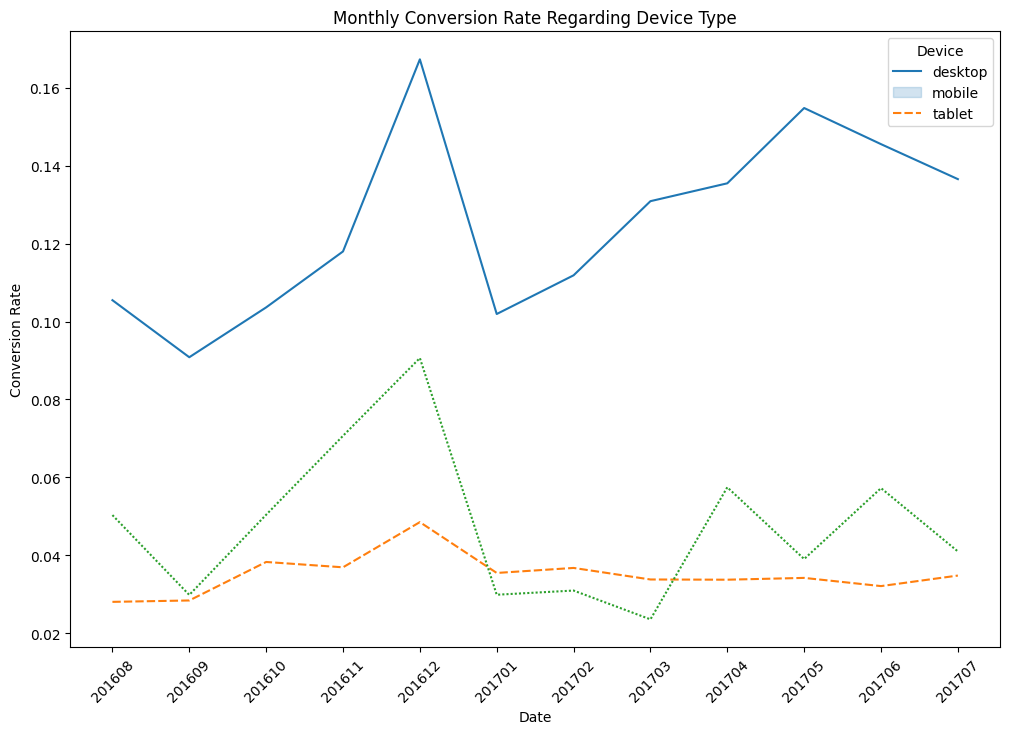

In [69]:
# 시각화
plt.figure(figsize=(12, 8))
sns.lineplot(data=conversion_rates_df)
plt.title('Monthly Conversion Rate Regarding Device Type')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.legend(title='Device', labels=conversion_rates_df.columns)
plt.show()


1611에 모든 device의 전환율이 증가했다가 1612 ~ 1701에 폭락함 . 무슨 일이.. 뭘 했지? 연말/연초 기념 세일을 했나? 블랙프라이데이? 유료 광고를 집행했나? 아니면 ui/ux가 바뀌었나? 근데 세일을 했다기에는 1609부터 꾸준한 증가가 있었음 

In [70]:
# 결제 -> 구매 완료 단계로 넘어가는 것도 확인해보자 원래 이렇게 낮은지 

filtered_data = device_monthly_conv[device_monthly_conv['action'].isin(['결제', '구매 완료'])]
pivot_table = filtered_data.pivot_table(index='YearMonth', columns=['Device', 'action'], values='users', aggfunc='sum')

conversion_rates = {}
for device in pivot_table.columns.levels[0]:
    conversion_rates[device] = pivot_table[(device, '구매 완료')] / pivot_table[(device, '결제')]

conversion_rates_df2 = pd.DataFrame(conversion_rates, index=pivot_table.index)

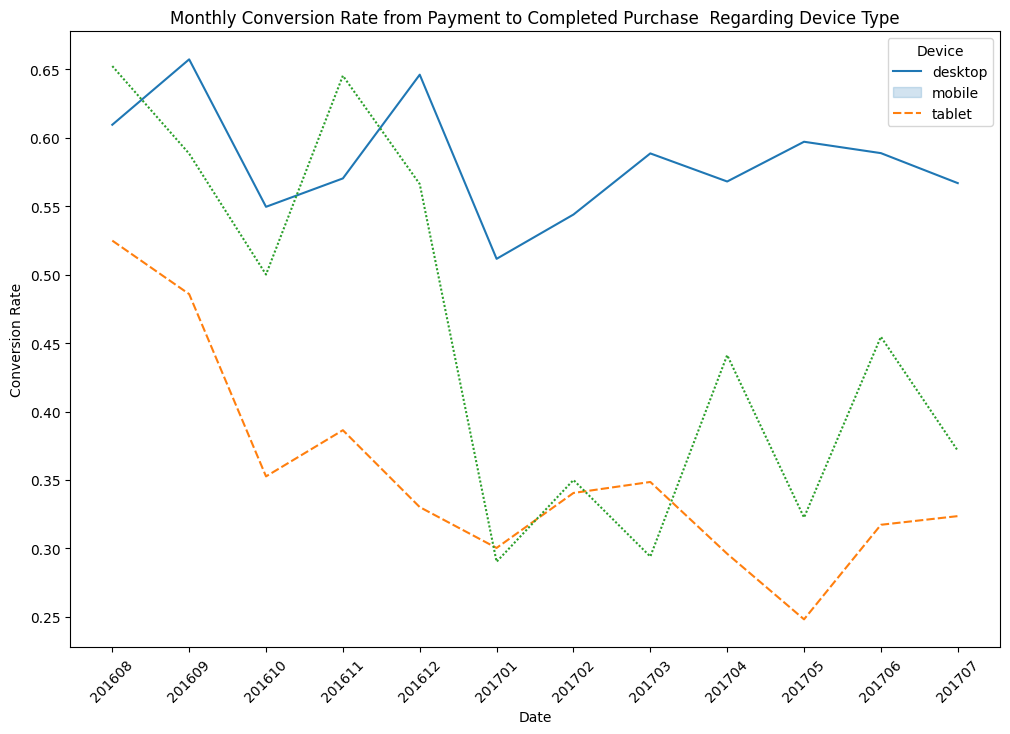

In [72]:
# 시각화
plt.figure(figsize=(12, 8))
sns.lineplot(data=conversion_rates_df2)
plt.title('Monthly Conversion Rate from Payment to Completed Purchase  Regarding Device Type')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.legend(title='Device', labels=conversion_rates_df.columns)
plt.show()

이때 결제창 ui/ux에 변화가 있었나? 아니면 결제 로딩 시간이 오래 걸렸나? 

특히 mobile의 결제창 - 구매 완료 전환률은 1612 ~ 1701을 기준으로 거의 반토막이 났다.

desktop의 범위는 0.5 ~ 0.65 사이를 원래 왔다 갔다 하는 것 같음 


In [83]:
query = """
SELECT hits.type
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
  UNNEST(hits) AS hits
GROUP BY hits.type
"""

conv = client.query(query).result().to_dataframe()

conv

type
0  EVENT
1   PAGE

In [81]:
# device별 결제 로딩 시간을 구해보자
# hits.latencyTracking.pageLoadTime 사용 

query = """
SELECT
  device.deviceCategory AS Device,
  FORMAT_DATE("%Y%m", PARSE_DATE("%Y%m%d", _TABLE_SUFFIX)) AS YearMonth,
  AVG(hits.latencyTracking.pageLoadTime) AS AvgPageLoadTime,
  CASE 
        WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
        WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
        WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
        WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
  UNNEST(hits) AS hits
WHERE
  hits.eCommerceAction.action_type IN ('5', '6') AND
  hits.latencyTracking.pageLoadTime IS NOT NULL
GROUP BY
  Device,
  YearMonth,
  action
ORDER BY
  YearMonth, Device
"""

device_time_conv = client.query(query).result().to_dataframe()

In [85]:
merged_df = device_time_conv.pivot_table(index=['YearMonth', 'Device'], columns='action', values='AvgPageLoadTime').reset_index()

merged_df['LoadTimeDifference'] = merged_df['구매 완료'] - merged_df['결제']


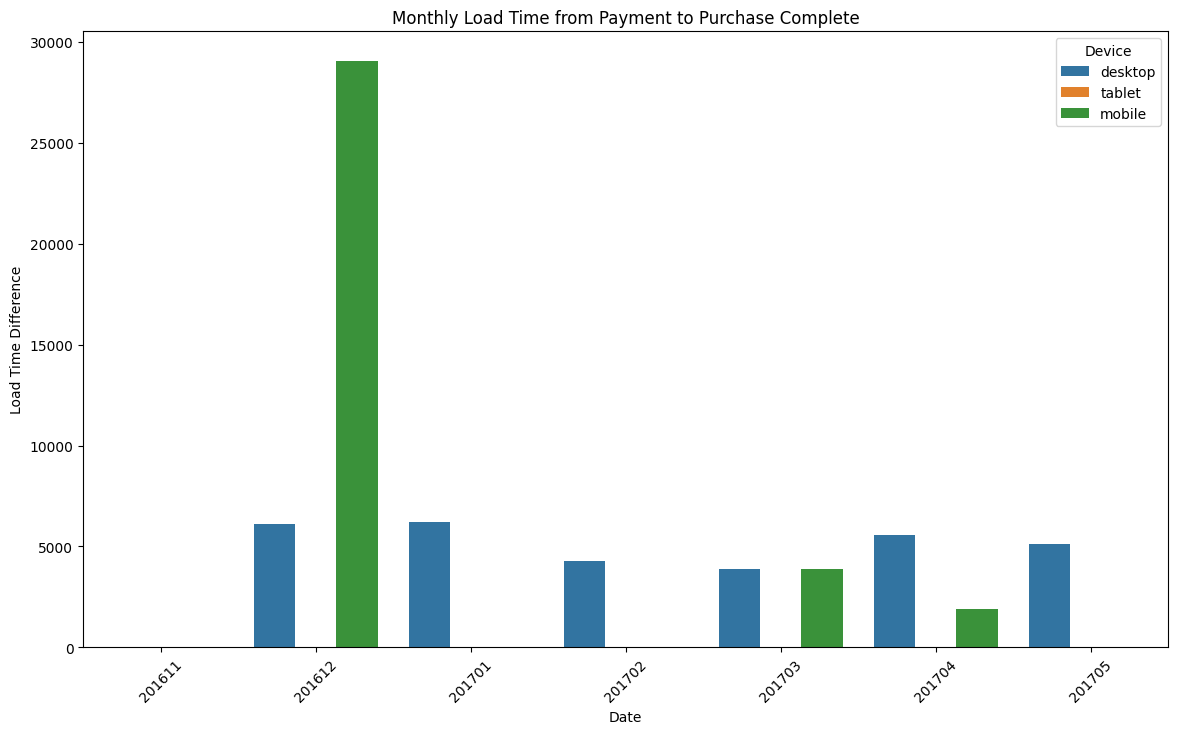

In [88]:
plt.figure(figsize=(14, 8))
sns.barplot(data=merged_df, x='YearMonth', y='LoadTimeDifference', hue='Device')
plt.title('Monthly Load Time from Payment to Purchase Complete')
plt.xlabel('Date')
plt.ylabel('Load Time Difference')
plt.xticks(rotation=45)
plt.legend(title='Device')
plt.show()

몇몇 단계/기기에선 데이터의 부재로 확인할 수 없었지만, 

201612 ~ 201701의 경우 mobile 유저의 경우 결제 ~ 구매 완료 과정에서 다른 때보다 6배 오래 걸렸음을 확인할 수 있음. 왜 오래 걸렸지? 서버 문제?

이때문에 결제 -> 구매 완료 전환률이 폭락한 게 아닐까 싶음.

이것도 통계 검정 가능한가?

#### 9) 결제 시간대별 코호트 분석

In [ ]:
# 변수 hits.hour 사용

query = """
SELECT
  FORMAT_DATE("%Y%m", PARSE_DATE("%Y%m%d", _TABLE_SUFFIX)) AS YearMonth,
  hits.hour AS Hour,
  CASE 
        WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
        WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
        WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
        WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
  COUNT(DISTINCT fullVisitorID) AS users    
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
  UNNEST(hits) AS hits
WHERE
  hits.eCommerceAction.action_type IN ('1', '6')
GROUP BY
  YearMonth, Hour, action
ORDER BY
  YearMonth, Hour
"""

time_conv = client.query(query).result().to_dataframe()

KeyboardInterrupt: 

In [ ]:
# '제품 목록'과 '구매 완료'로 분리된 데이터를 YearMonth와 Hour를 기준으로 병합합니다.
pivot_df = time_conv.pivot_table(index=['YearMonth', 'Hour'], columns='action', values='users', aggfunc='sum').reset_index()

# '제품 목록 대비 구매 완료' 비율을 계산합니다.
pivot_df['ConversionRate'] = pivot_df['구매 완료'] / pivot_df['제품 목록']

# 월별, 시간대별 전환율을 시각화하기 위한 피벗 테이블 생성
pivot_table = pivot_df.pivot("Hour", "YearMonth", "ConversionRate")

C:\Users\USER\AppData\Local\Temp\ipykernel_26856\2124412632.py:8: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



In [ ]:
pivot_table

In [99]:
pivot_table.drop(columns='201708', inplace = True)

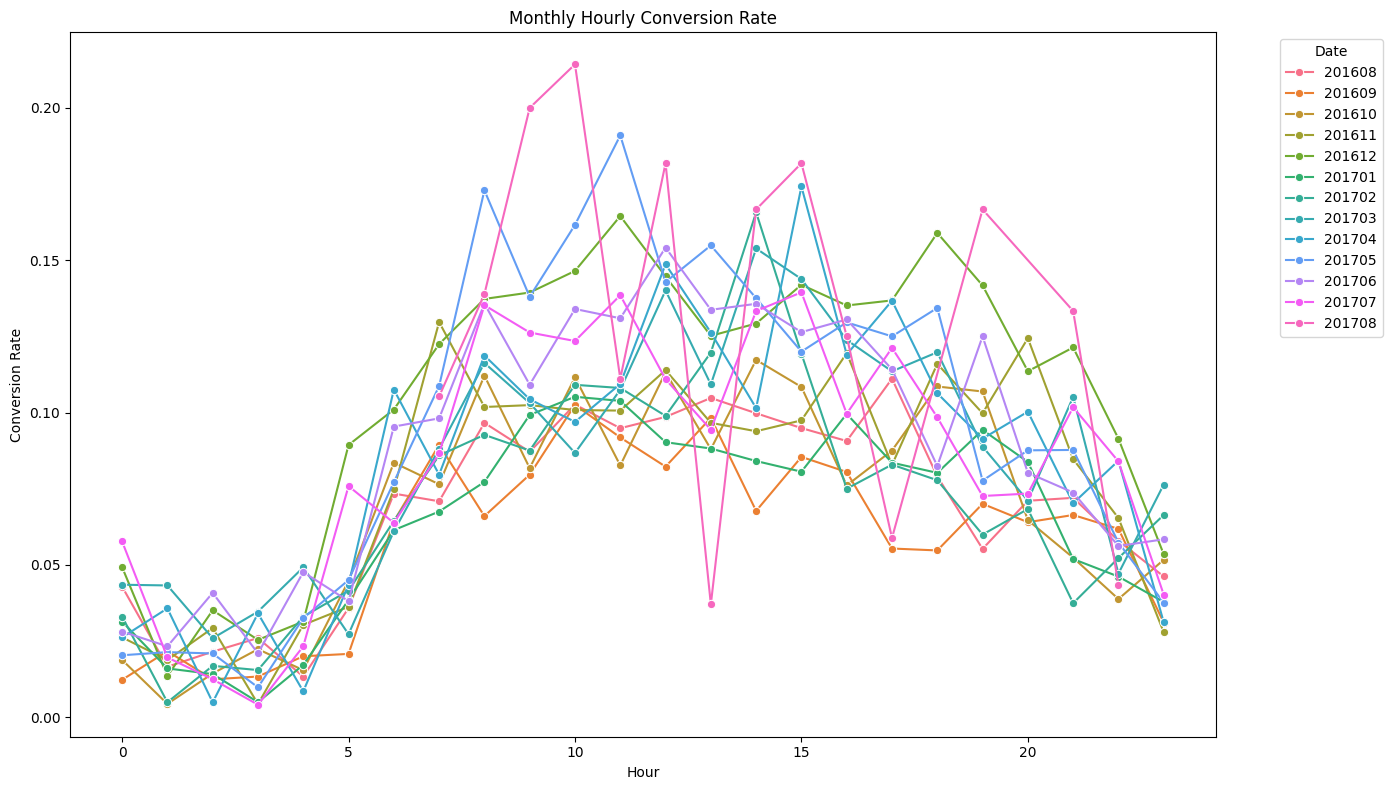

In [105]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_df, x='Hour', y='ConversionRate', hue='YearMonth', marker='o')
plt.title('Monthly Hourly Conversion Rate')
plt.ylabel('Conversion Rate')
plt.xlabel('Hour')
plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

앞서한 분석들 전부 기간별로 다시 시각화 해서 살펴볼 것 + 결제 시간대별 코호트 분석하고 .. 어떻게 하면 mau가 증가할까

#### 대륙 코호트

In [119]:
# 변수 hits.hour 사용

query = """
SELECT 
    geoNetwork.continent AS Continent,
    FORMAT_DATE("%Y%m", PARSE_DATE("%Y%m%d", _TABLE_SUFFIX)) AS YearMonth,
    CASE 
        WHEN hits.eCommerceAction.action_type = '1' THEN '제품 목록'
        WHEN hits.eCommerceAction.action_type = '2' THEN '제품 세부 정보 보기'
        WHEN hits.eCommerceAction.action_type = '5' THEN '결제'
        WHEN hits.eCommerceAction.action_type = '6' THEN '구매 완료'
    END AS action,
    COUNT(DISTINCT fullVisitorID) AS users
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits, 
    UNNEST(hits.product) AS product
WHERE 
    hits.eCommerceAction.action_type IN ('1', '2', '5', '6')
    AND _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
GROUP BY 
    Continent,
    YearMonth,
    action
ORDER BY 
    Continent, YearMonth, action
"""

geo_table = client.query(query).result().to_dataframe()

In [128]:
# '구매 완료'와 '제품 목록'을 YearMonth와 Continent 별로 집계
purchase_completed = geo_table[geo_table['action'] == '구매 완료'].groupby(['YearMonth', 'Continent'])['users'].sum().reset_index(name='구매 완료')
product_listed = geo_table[geo_table['action'] == '제품 목록'].groupby(['YearMonth', 'Continent'])['users'].sum().reset_index(name='제품 목록')

# 데이터 병합
merged_df = pd.merge(product_listed, purchase_completed, on=['YearMonth', 'Continent'])

# 전환율 계산
merged_df['conversion_rate'] = merged_df['구매 완료'] / merged_df['제품 목록']

# 대륙별 전환율 계산 (여기서는 예제 데이터가 모두 Africa이므로 하나의 값만 나옴)
continent_conversion_rate = merged_df.groupby('Continent')['conversion_rate'].mean().reset_index()


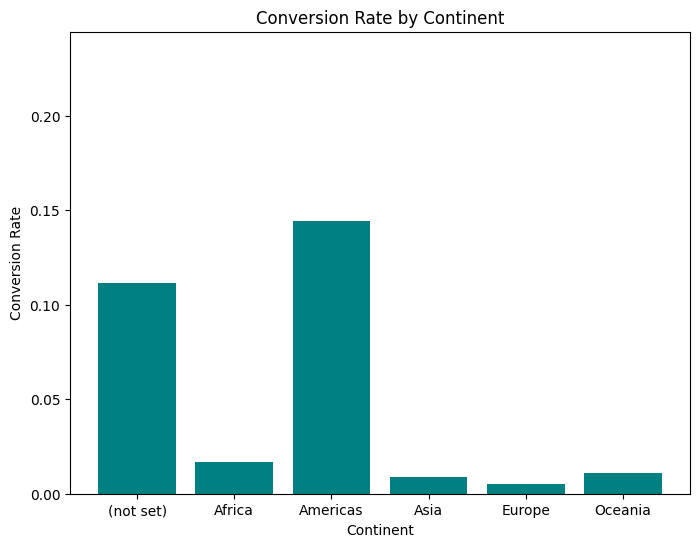

In [129]:
# 시각화
plt.figure(figsize=(8, 6))
plt.bar(continent_conversion_rate['Continent'], continent_conversion_rate['conversion_rate'], color='teal')
plt.title('Conversion Rate by Continent')
plt.xlabel('Continent')
plt.ylabel('Conversion Rate')
plt.ylim(0, max(continent_conversion_rate['conversion_rate']) + 0.1)  # 전환율 최대값보다 약간 더 높게 설정
plt.show()


## 2-2. 매출 코호트 

월별 매출 추이로 코호트 차트 살펴보기 

# 3. Retention 분석

#### 구매 완료

시간의 흐름에 따른 구매 완료 행동의 반복 여부를 살펴보자

In [63]:
query = """
-- 구매 내역 전체
WITH Purchases AS (
  SELECT
    fullVisitorId,
    FORMAT_DATE('%Y%m', PARSE_DATE('%Y%m%d', date)) AS PurchaseMonth,
    hits.eCommerceAction.action_type AS ActionType
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE
    hits.eCommerceAction.action_type = '6'
),
-- 첫 번째 구매 내역 
FirstPurchase AS (
  SELECT
    fullVisitorId,
    MIN(PurchaseMonth) AS FirstPurchaseMonth
  FROM Purchases
  GROUP BY fullVisitorId
)
-- 첫 번째 구매 내역 테이블 & 전체 구매 내역 테이블 병합 후
-- m = 첫 구매 시점부터 m+1, m+2 계산
SELECT
  fp.FirstPurchaseMonth,
  p.PurchaseMonth,
  COUNT(DISTINCT fp.fullVisitorId) AS Users
FROM
  FirstPurchase fp
JOIN
  Purchases p ON fp.fullVisitorId = p.fullVisitorId
GROUP BY
  fp.FirstPurchaseMonth,
  p.PurchaseMonth
ORDER BY
  fp.FirstPurchaseMonth,
  p.PurchaseMonth
"""

reten_table = client.query(query).result().to_dataframe()

In [67]:
# 리텐션 계산을 위한 준비: 각 구매월로부터 첫 구매월까지의 기간(월 단위) 계산
reten_table['CohortPeriod'] = (
    pd.to_datetime(reten_table['PurchaseMonth'], format='%Y%m') -
    pd.to_datetime(reten_table['FirstPurchaseMonth'], format='%Y%m')
).dt.days // 30

cohort_pivot = reten_table.pivot_table(
    index='FirstPurchaseMonth',
    columns='CohortPeriod',
    values='Users',
    aggfunc='sum'  # 중복 값을 합산하도록 설정
)

cohort_pivot.reset_index(inplace=True)  # 인덱스를 리셋하여 'FirstPurchaseMonth'를 열로 변환합니다.
cohort_pivot.columns.name = None  # 열 이름의 이름을 제거합니다.

# 결과 출력
cohort_pivot


FirstPurchaseMonth     0     1     2     3     4     5     6     7     8  \
0              201608  1046    46    21    13    11     5     3     3  <NA>   
1              201609   747    28     7     6     2  <NA>     2     2  <NA>   
2              201610   769    40    27    17    16    14    11     8     4   
3              201611   804    41    25     8    13     8     8     2     4   
4              201612  1233    22    16    15     1     5     2     3  <NA>   
5              201701   591    27  <NA>     2     4     2  <NA>  <NA>  <NA>   
6              201702   632    17    12  <NA>     4     6  <NA>  <NA>  <NA>   
7              201703   726    33     9    12     3  <NA>  <NA>  <NA>  <NA>   
8              201704   796    40    11     3  <NA>  <NA>  <NA>  <NA>  <NA>   
9              201705   967    26    16     1  <NA>  <NA>  <NA>  <NA>  <NA>   
10             201706   813    37  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
11             201707   890     6  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
12             201708    34  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   

       9    10  
0      2     1  
1      1  <NA>  
2      2  <NA>  
3      1  <NA>  
4   <NA>  <NA>  
5   <NA>  <NA>  
6   <NA>  <NA>  
7   <NA>  <NA>  
8   <NA>  <NA>  
9   <NA>  <NA>  
10  <NA>  <NA>  
11  <NA>  <NA>  
12  <NA>  <NA>

MAu 수에 비해서 결제자 수가 굉장히 작은 듯 함

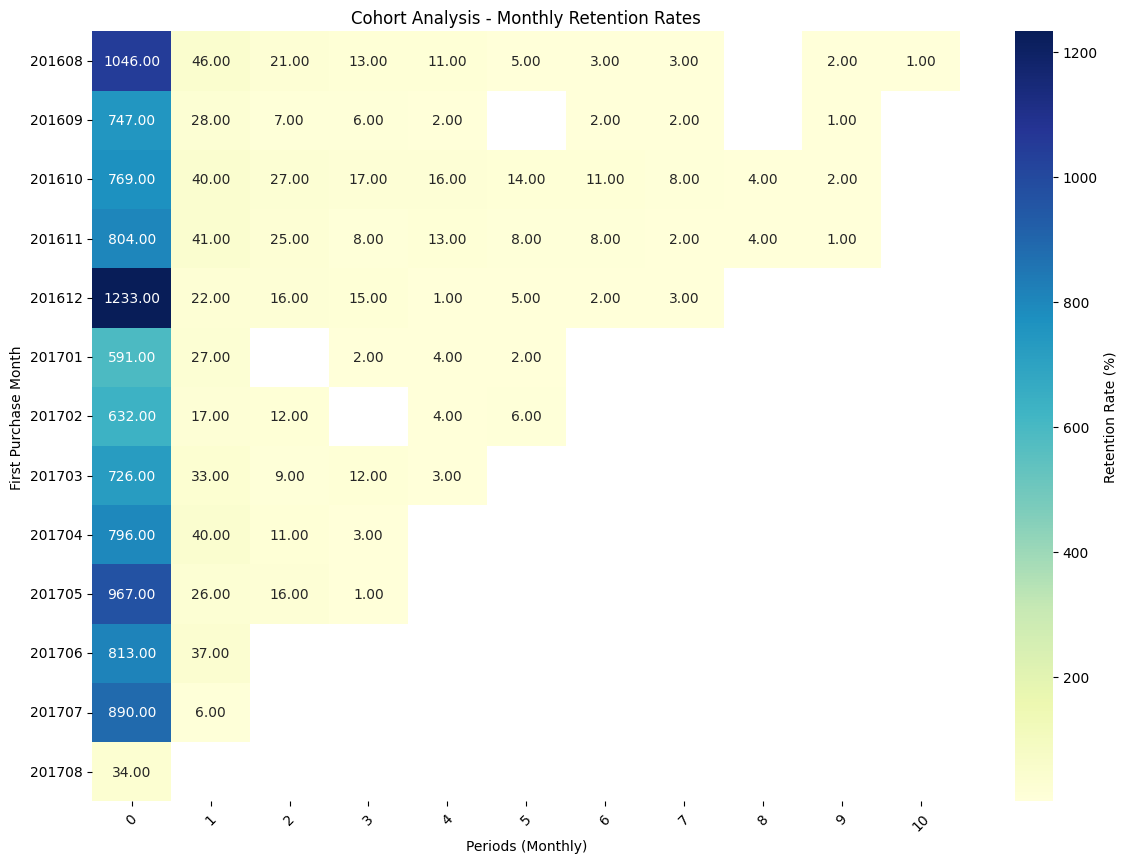

In [68]:
# FirstPurchaseMonth 열을 인덱스로 설정합니다.
cohort_pivot.set_index('FirstPurchaseMonth', inplace=True)

# 데이터 타입을 확인하고 필요한 경우 숫자형으로 변환합니다.
cohort_pivot = cohort_pivot.astype(float)

# 히트맵으로 시각화
plt.figure(figsize=(14, 10))
sns.heatmap(cohort_pivot, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Retention Rate (%)'})
plt.title('Cohort Analysis - Monthly Retention Rates')
plt.ylabel('First Purchase Month')
plt.xlabel('Periods (Monthly)')
plt.xticks(np.arange(0.5, len(cohort_pivot.columns)+0.5), cohort_pivot.columns, rotation=45)
plt.yticks(rotation=0)
plt.show()


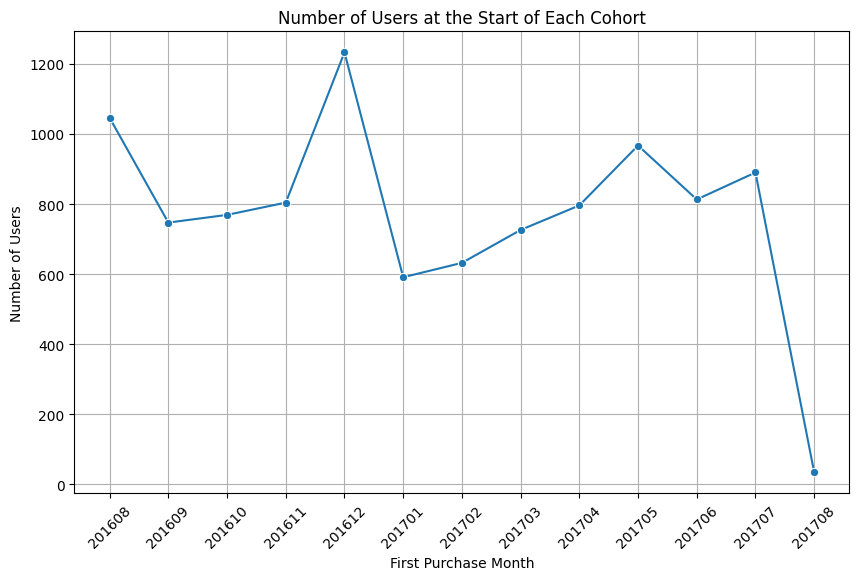

In [61]:
data = {
    'FirstPurchaseMonth': ['201608', '201609', '201610', '201611', '201612', 
                           '201701', '201702', '201703', '201704', '201705', 
                           '201706', '201707', '201708'],
    '0': [1046, 747, 769, 804, 1233, 591, 632, 726, 796, 967, 813, 890, 34]
}

df = pd.DataFrame(data)

# 'FirstPurchaseMonth' 열을 기반으로 Line Plot 그리기
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='FirstPurchaseMonth', y='0', marker='o')
plt.title('Number of Users at the Start of Each Cohort')
plt.xlabel('First Purchase Month')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

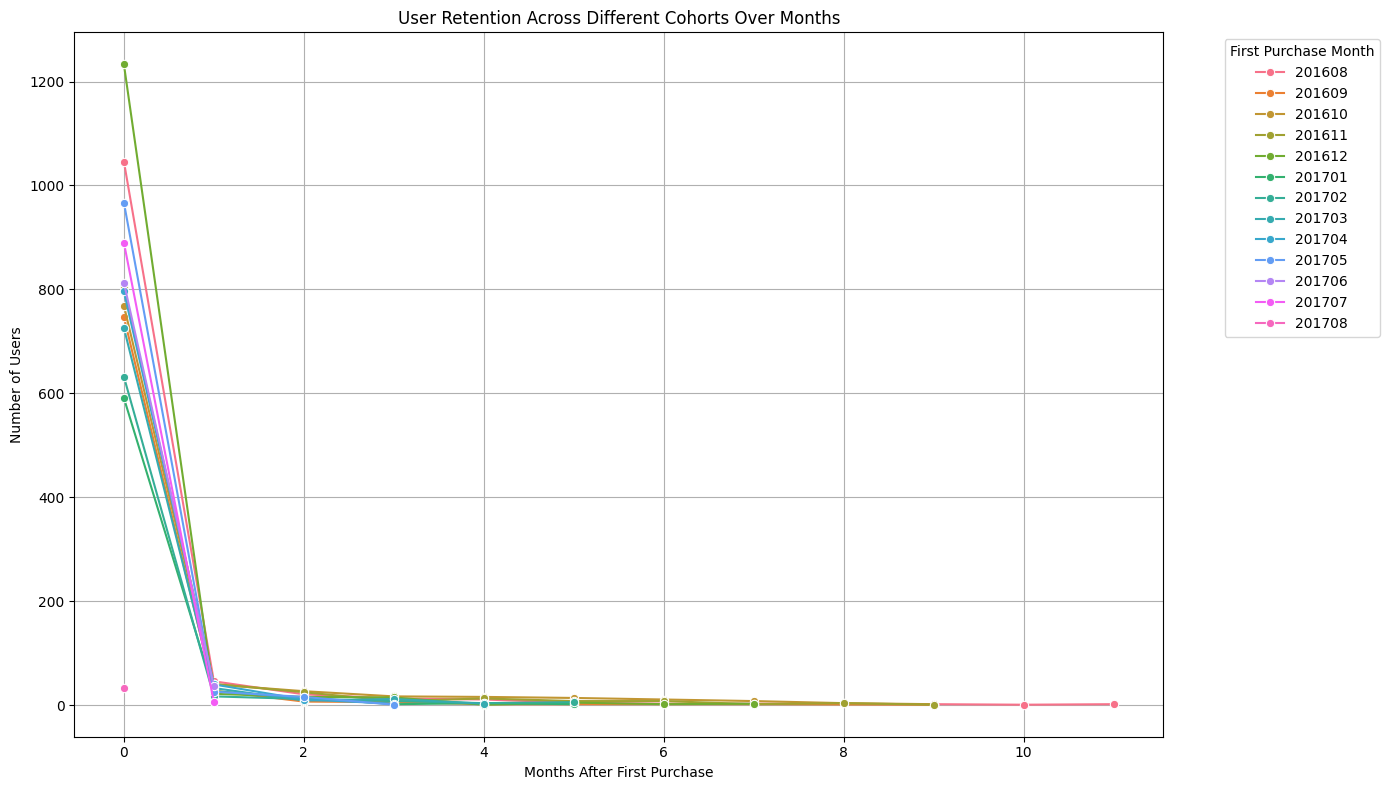

In [66]:
# 데이터 프레임 생성
df = pd.DataFrame({
    'FirstPurchaseMonth': ['201608', '201609', '201610', '201611', '201612', '201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708'],
    0: [1046, 747, 769, 804, 1233, 591, 632, 726, 796, 967, 813, 890, 34],
    1: [46, 28, 40, 41, 22, 27, 17, 33, 40, 26, 37, 6, np.nan],
    2: [21, 7, 27, 25, 16, np.nan, 12, 9, 11, 16, np.nan, np.nan, np.nan],
    3: [13, 6, 17, 8, 15, 2, np.nan, 12, 3, 1, np.nan, np.nan, np.nan],
    4: [11, 2, 16, 13, 1, 4, 4, 3, np.nan, np.nan, np.nan, np.nan, np.nan],
    5: [5, np.nan, 14, 8, 5, 2, 6, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    6: [3, 2, 11, 8, 2, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    7: [3, 2, 8, 2, 3, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    8: [np.nan, np.nan, 4, 4, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    9: [2, 1, 2, 1, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    10: [1, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
    11: [2, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
}).set_index('FirstPurchaseMonth')

# 데이터 프레임을 긴 형태로 변환
df_long = df.reset_index().melt(id_vars='FirstPurchaseMonth', var_name='Month', value_name='Users').dropna()

# 플롯 생성
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_long, x='Month', y='Users', hue='FirstPurchaseMonth', marker='o')
plt.title('User Retention Across Different Cohorts Over Months')
plt.xlabel('Months After First Purchase')
plt.ylabel('Number of Users')
plt.legend(title='First Purchase Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



해석해볼 것!

<하나의 코호트 내에서 기강네 따른 유지율의 추이>
* 초기에 리텐션이 떨어지는 속도가 급격함 (1 -> 0.0x 수준): 활성화 프로세스가 잘못된 걸까? 왜 재구매율이 떨어지는 걸까? 리마켓팅은 진행하고 있는가?

<서로 다른 코호트의 동일한 기간의 유지율>
첫 번째 결제 기준 다음 달의 결제 유지율:  
* 16년도 하반기: 평균 0.32
* 17년도 상반기: 평균 0.21

<기간에 따른 코호트의 규모>
* 결제자가 유지되는 추세인 것 같다 (201708 제외)

In [72]:
# DataFrame을 생성하고, NA 값을 0으로 대체합니다.
df = pd.DataFrame({
    'FirstPurchaseMonth': ['201608', '201609', '201610', '201611', '201612', '201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708'],
    0: [1046, 747, 769, 804, 1233, 591, 632, 726, 796, 967, 813, 890, 34],
    1: [46, 28, 40, 41, 22, 27, 17, 33, 40, 26, 37, 6, 0],
    2: [21, 7, 27, 25, 16, 0, 12, 9, 11, 16, 0, 0, 0],
    3: [13, 6, 17, 8, 15, 2, 0, 12, 3, 1, 0, 0, 0],
    4: [11, 2, 16, 13, 1, 4, 4, 3, 0, 0, 0, 0, 0],
    5: [5, 0, 14, 8, 5, 2, 6, 0, 0, 0, 0, 0, 0],
    6: [3, 2, 11, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0],
    7: [3, 2, 8, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0],
    8: [0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    9: [2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    10: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    11: [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
}).set_index('FirstPurchaseMonth').fillna(0)



# '0' 열 값을 기준으로 각 컬럼의 비율 계산
for column in df.columns[1:]:
    df[column] = (df[column] / df[0]) * 100

# '0' 열의 각 값을 100으로 설정
df[0] = 100

df

# 데이터 프레임을 긴 형태로 변환
df_long = df.reset_index().melt(id_vars='FirstPurchaseMonth', var_name='Month', value_name='Users').dropna()

# 플롯 생성
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_long, x='Month', y='Users', hue='FirstPurchaseMonth', marker='o')
plt.title('User Retention Across Different Cohorts Over Months')
plt.xlabel('Months After First Purchase')
plt.ylabel('Number of Users')
plt.legend(title='First Purchase Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:


# 히트맵으로 시각화
plt.figure(figsize=(14, 10))
sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Retention Rate (%)'})
plt.title('Cohort Analysis - Monthly Retention Rates')
plt.ylabel('First Purchase Month')
plt.xlabel('Periods (Monthly)')
plt.xticks(np.arange(0.5, len(df.columns)+0.5), df.columns, rotation=45)
plt.yticks(rotation=0)
plt.show()


# 4. Referral 분석